In [ ]:
import tensorflow as tf

#SIMULACIÓN

In [ ]:
import tensorflow as tf

# Desactivar la ejecución ansiosa
tf.compat.v1.disable_eager_execution()

# Definir las características
batch_size = 128
input_channels = 96
output_channels = 256
kernel_size = (7, 7)
input_size = (40, 40)

# Crear un placeholder para la entrada (batch_size, height, width, channels)
input_placeholder = tf.compat.v1.placeholder(tf.float32, shape=(batch_size, input_size[0], input_size[1], input_channels))

# Definir la capa convolucional
conv_layer = tf.keras.layers.Conv2D(filters=output_channels, kernel_size=kernel_size, strides=(1, 1), padding='valid', activation=tf.nn.relu)

# Pasar la entrada a través de la capa convolucional
output = conv_layer(input_placeholder)

# Inicializar TensorFlow
sess = tf.compat.v1.Session()
sess.run(tf.compat.v1.global_variables_initializer())

# Simular datos de entrada
import numpy as np
input_data = np.random.rand(batch_size, input_size[0], input_size[1], input_channels)

# Ejecutar la sesión para obtener la salida
output_data = sess.run(output, feed_dict={input_placeholder: input_data})

# Imprimir la forma de la salida
print("Shape of the output:", output_data.shape)


In [ ]:
import numpy as np
import random
import tensorflow.compat.v1 as tf
from tensorflow import keras
tf.disable_v2_behavior()
tf.compat.v1.disable_resource_variables()


# Load training and test data (MNIST dataset):
dataLoader = keras.datasets.mnist
(features, labels), (testFeatures, testLabels) = dataLoader.load_data()
onehot_labels = np.zeros((labels.shape[0], 10))
onehot_labels[np.arange(labels.shape[0]), labels] = 1
labels = onehot_labels
features = features
testFeatures = testFeatures
onehot_testLabels = np.zeros((testLabels.shape[0], 10))
onehot_testLabels[np.arange(testLabels.shape[0]), testLabels] = 1
testLabels = onehot_testLabels

# Set the parameters:
NumClasses = 10
BatchLength = 16
Size = [28, 28, 1]
NumIteration = 40001
LearningRate = 1e-4
EvalFreq = 1000
NumKernels = [16, 32, 64]


# spectral pooling size:
#         1/2  - 0
#         6/8 - 1
specPoolSize = 0


def fourier_complex_relu(x):
    real = tf.real(x)
    imag = tf.imag(x)
    return tf.complex(tf.cast(real*real+imag*imag > 0.1, tf.float32)*real, tf.cast(real*real+imag*imag > 0.1, tf.float32)*imag)


def convolution_in_freq_domain_without_ifft(f_input, out_channels):
    in_shape = f_input.get_shape()
    bias_r = tf.get_variable('BiasReal', [out_channels], dtype=tf.float32)
    bias_c = tf.get_variable('BiasComp', [out_channels], dtype=tf.float32)
    bias = tf.complex(bias_r, bias_c)
    # Spectral pooling:
    if specPoolSize == 0:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 4), int(in_shape[2] // 4), 0], [-1, int(in_shape[1] // 2), int(in_shape[2] // 2), in_shape[-1]])
    elif specPoolSize == 1:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 8), int(in_shape[2] // 8), 0], [-1, int(in_shape[1]) - int(2 * in_shape[1] // 8), int(in_shape[2]) - int(2 * in_shape[2] // 8), in_shape[-1]])
    in_shape = f_input.get_shape()
    w_r = tf.get_variable('w_r', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w_i = tf.get_variable('w_i', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w = tf.complex(w_r, w_i)
    fourier_kernel = w
    fourier_kernel = tf.tile(tf.expand_dims(fourier_kernel, 0), [BatchLength, 1, 1, 1, 1])
    out = []
    for ind in range(out_channels):
        res = tf.multiply(f_input[:, :, :, :], fourier_kernel[:, :, :, :, ind])
        res = tf.add(res, bias[ind])
        res = tf.expand_dims(tf.reduce_sum(res, 3), -1)
        out.append(res)
    out = tf.concat(out, 3)# Con estas líneas utilizando tf.keras.layers.BatchNormalization
    norm_real = tf.keras.layers.BatchNormalization()(tf.real(out), training=True)
    norm_comp = tf.keras.layers.BatchNormalization()(tf.imag(out), training=True)

    out = tf.complex(norm_real, norm_comp)
    out = fourier_complex_relu(out)
    return out


tf.reset_default_graph()
InputData = tf.placeholder(tf.float32, [None] + Size)  # input images
OneHotLabels = tf.placeholder(tf.int32, [None, NumClasses])  # the expected outputs, labels


# Take the input to Fourier domain
CurrentInput = tf.cast(InputData, tf.complex64)
# Transponer solo si el tensor tiene más de 2 dimensiones
if len(Size) > 2:
    CurrentInput = tf.transpose(CurrentInput, [3, 0, 1, 2])
fourierInput = tf.fft2d(CurrentInput, name=None)
fourierInput = tf.transpose(fourierInput, [1, 2, 3, 0])
fourierInput = tf.roll(fourierInput, shift=[int(Size[0]//2), int(Size[1]//2)], axis=[1, 2])
CurrentFilters = Size[-1]
# a loop which creates all layers
for N in range(len(NumKernels)):
    with tf.variable_scope('conv' + str(N)):
        fourierInput = convolution_in_freq_domain_without_ifft(fourierInput, NumKernels[N])
with tf.variable_scope('FC'):
    fourierInput = tf.square(tf.real(fourierInput)) + tf.square(tf.imag(fourierInput))
    CurrentShape = fourierInput.get_shape()
    FeatureLength = int(CurrentShape[1]*CurrentShape[2]*CurrentShape[3])
    FC = tf.reshape(fourierInput, [-1, FeatureLength])
    W = tf.get_variable('W', [FeatureLength, NumClasses])
    FC = tf.matmul(FC, W)
    Bias = tf.get_variable('Bias', [NumClasses])
    FC = tf.add(FC, Bias)


with tf.name_scope('loss'):
    Loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=OneHotLabels, logits=FC))


with tf.name_scope('optimizer'):
    Optimizer = tf.train.AdamOptimizer(LearningRate).minimize(Loss)


with tf.name_scope('accuracy'):
    CorrectPredictions = tf.equal(tf.argmax(FC, 1), tf.argmax(OneHotLabels, 1))
    Accuracy = tf.reduce_mean(tf.cast(CorrectPredictions, tf.float32))


Init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as Sess:
    Sess.run(Init)
    Step = 1
    while Step < NumIteration:
        UsedInBatch = random.sample(range(features.shape[0]), BatchLength)
        batch_xs = features[UsedInBatch, :]
        batch_ys = labels[UsedInBatch, :]
        batch_xs = np.reshape(batch_xs, [BatchLength]+Size)
        _, Acc, L = Sess.run([Optimizer, Accuracy, Loss], feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})
        if (Step % 100) == 0:
            print("Iteration: "+str(Step))
            print("Accuracy:" + str(Acc))
            print("Loss:" + str(L))
        if (Step % EvalFreq) == 0:
            SumAcc = 0.0
            for i in range(0, testFeatures.shape[0]):
                batch_xs = testFeatures[i, :]
                batch_ys = testLabels[i, :]
                batch_xs = np.reshape(batch_xs, [1]+Size)
                batch_ys = np.reshape(batch_ys, [1, NumClasses])
                a = Sess.run(Accuracy, feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})
                SumAcc += a
            print("Independent Test set: "+str(float(SumAcc)/testFeatures.shape[0]))
        Step += 1

Iteration: 100
Accuracy:0.6875
Loss:1.1474257
Iteration: 200
Accuracy:0.875
Loss:0.73773456
Iteration: 300
Accuracy:0.5625
Loss:1.5835687
Iteration: 400
Accuracy:0.8125
Loss:0.63814807
Iteration: 500
Accuracy:0.875
Loss:1.03096
Iteration: 600
Accuracy:0.9375
Loss:0.32407376
Iteration: 700
Accuracy:0.75
Loss:0.74721706
Iteration: 800
Accuracy:0.875
Loss:0.52197695
Iteration: 900
Accuracy:0.875
Loss:0.29688045
Iteration: 1000
Accuracy:0.8125
Loss:0.7232912
Independent Test set: 0.6976
Iteration: 1100
Accuracy:0.8125
Loss:0.7491254
Iteration: 1200
Accuracy:0.75
Loss:1.105644
Iteration: 1300
Accuracy:0.875
Loss:0.19295332
Iteration: 1400
Accuracy:0.8125
Loss:0.7719172
Iteration: 1500
Accuracy:0.875
Loss:0.4671176
Iteration: 1600
Accuracy:0.875
Loss:0.4197607
Iteration: 1700
Accuracy:0.8125
Loss:0.4979406
Iteration: 1800
Accuracy:0.8125
Loss:0.50201404
Iteration: 1900
Accuracy:0.6875
Loss:0.4446199
Iteration: 2000
Accuracy:0.8125
Loss:0.5613357
Independent Test set: 0.7839
Iteration: 2100
A

In [ ]:
pip install matplotlib

# RECONOCIMIENTO DE DÍGITOS


In [ ]:
import numpy as np
import random
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
from tensorflow import keras

tf.disable_v2_behavior()
tf.compat.v1.disable_resource_variables()

# Load training and test data (MNIST dataset):
dataLoader = keras.datasets.mnist
(features, labels), (testFeatures, testLabels) = dataLoader.load_data()
onehot_labels = np.zeros((labels.shape[0], 10))
onehot_labels[np.arange(labels.shape[0]), labels] = 1
labels = onehot_labels
features = features
testFeatures = testFeatures
onehot_testLabels = np.zeros((testLabels.shape[0], 10))
onehot_testLabels[np.arange(testLabels.shape[0]), testLabels] = 1
testLabels = onehot_testLabels

# Set the parameters:
NumClasses = 10
BatchLength = 16
Size = [28, 28, 1]
NumIteration = 40001
LearningRate = 1e-4
EvalFreq = 1000
NumKernels = [16, 32, 64]

# Spectral pooling size:
#         1/2  - 0
#         6/8 - 1
specPoolSize = 0


def fourier_complex_relu(x):
    real = tf.real(x)
    imag = tf.imag(x)
    return tf.complex(tf.cast(real * real + imag * imag > 0.1, tf.float32) * real,
                      tf.cast(real * real + imag * imag > 0.1, tf.float32) * imag)


def convolution_in_freq_domain_without_ifft(f_input, out_channels):
    in_shape = f_input.get_shape()
    bias_r = tf.get_variable('BiasReal', [out_channels], dtype=tf.float32)
    bias_c = tf.get_variable('BiasComp', [out_channels], dtype=tf.float32)
    bias = tf.complex(bias_r, bias_c)
    # Spectral pooling:
    if specPoolSize == 0:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 4), int(in_shape[2] // 4), 0],
                           [-1, int(in_shape[1] // 2), int(in_shape[2] // 2), in_shape[-1]])
    elif specPoolSize == 1:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 8), int(in_shape[2] // 8), 0],
                           [-1, int(in_shape[1]) - int(2 * in_shape[1] // 8), int(in_shape[2]) - int(2 * in_shape[2] // 8),
                            in_shape[-1]])
    in_shape = f_input.get_shape()
    w_r = tf.get_variable('w_r', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w_i = tf.get_variable('w_i', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w = tf.complex(w_r, w_i)
    fourier_kernel = w
    fourier_kernel = tf.tile(tf.expand_dims(fourier_kernel, 0), [BatchLength, 1, 1, 1, 1])
    out = []
    for ind in range(out_channels):
        res = tf.multiply(f_input[:, :, :, :], fourier_kernel[:, :, :, :, ind])
        res = tf.add(res, bias[ind])
        res = tf.expand_dims(tf.reduce_sum(res, 3), -1)
        out.append(res)
    out = tf.concat(out, 3)# Con estas líneas utilizando tf.keras.layers.BatchNormalization
    norm_real = tf.keras.layers.BatchNormalization()(tf.real(out), training=True)
    norm_comp = tf.keras.layers.BatchNormalization()(tf.imag(out), training=True)

    out = tf.complex(norm_real, norm_comp)
    out = fourier_complex_relu(out)
    return out


tf.reset_default_graph()
InputData = tf.placeholder(tf.float32, [None] + Size)  # input images
OneHotLabels = tf.placeholder(tf.int32, [None, NumClasses])  # the expected outputs, labels

# Take the input to Fourier domain
CurrentInput = tf.cast(InputData, tf.complex64)
CurrentInput = tf.transpose(CurrentInput, [3, 0, 1, 2])
fourierInput = tf.fft2d(CurrentInput, name=None)
fourierInput = tf.transpose(fourierInput, [1, 2, 3, 0])
fourierInput = tf.roll(fourierInput, shift=[int(Size[0] // 2), int(Size[1] // 2)], axis=[1, 2])
CurrentFilters = Size[-1]

# a loop which creates all layers
for N in range(len(NumKernels)):
    with tf.variable_scope('conv' + str(N)):
        fourierInput = convolution_in_freq_domain_without_ifft(fourierInput, NumKernels[N])

with tf.variable_scope('FC'):
    fourierInput = tf.square(tf.real(fourierInput)) + tf.square(tf.imag(fourierInput))
    CurrentShape = fourierInput.get_shape()
    FeatureLength = int(CurrentShape[1] * CurrentShape[2] * CurrentShape[3])
    FC = tf.reshape(fourierInput, [-1, FeatureLength])
    W = tf.get_variable('W', [FeatureLength, NumClasses])
    FC = tf.matmul(FC, W)
    Bias = tf.get_variable('Bias', [NumClasses])
    FC = tf.add(FC, Bias)

with tf.name_scope('loss'):
    Loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=OneHotLabels, logits=FC))

with tf.name_scope('optimizer'):
    Optimizer = tf.train.AdamOptimizer(LearningRate).minimize(Loss)

with tf.name_scope('accuracy'):
    CorrectPredictions = tf.equal(tf.argmax(FC, 1), tf.argmax(OneHotLabels, 1))
    Accuracy = tf.reduce_mean(tf.cast(CorrectPredictions, tf.float32))

Init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.compat.v1.Session(config=config) as Sess:
    Sess.run(Init)
    Step = 1
    while Step < NumIteration:
        UsedInBatch = random.sample(range(features.shape[0]), BatchLength)
        batch_xs = features[UsedInBatch, :]
        batch_ys = labels[UsedInBatch, :]
        batch_xs = np.reshape(batch_xs, [BatchLength] + Size)
        _, Acc, L = Sess.run([Optimizer, Accuracy, Loss], feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})
        if (Step % 100) == 0:
            print("Iteration: " + str(Step))
            print("Accuracy:" + str(Acc))
            print("Loss:" + str(L))
        if (Step % EvalFreq) == 0:
            SumAcc = 0.0
            for i in range(0, testFeatures.shape[0]):
                batch_xs = testFeatures[i, :]
                batch_ys = testLabels[i, :]
                batch_xs = np.reshape(batch_xs, [1] + Size)
                batch_ys = np.reshape(batch_ys, [1, NumClasses])
                a = Sess.run(Accuracy, feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})
                SumAcc += a
            print("Independent Test set: " + str(float(SumAcc) / testFeatures.shape[0]))
        Step += 1

    # Después de imprimir la forma de la salida
    print("Forma de la salida:", FC.shape)

    # Visualizar algunas imágenes y sus predicciones
    num_visualize = 5  # Puedes ajustar el número de imágenes a visualizar

    # Seleccionar aleatoriamente algunas muestras del conjunto de prueba
    visualize_indices = np.random.choice(testFeatures.shape[0], num_visualize, replace=False)

    # Crear una sesión sin inicializar explícitamente las variables
    for i in visualize_indices:
        # Obtener la imagen y la etiqueta verdadera
        input_image = testFeatures[i, :]
        true_label = testLabels[i, :]

        # Preprocesar la entrada para que sea compatible con la red neuronal
        input_image = np.reshape(input_image, [1] + Size)

        # Obtener la predicción del modelo
        prediction = np.argmax(Sess.run(FC, feed_dict={InputData: input_image}), axis=1)

        # Visualizar la imagen, la etiqueta verdadera y la predicción
        plt.imshow(np.squeeze(input_image), cmap='gray')
        plt.title(f'Etiqueta real: {np.argmax(true_label)}, Etiqueta predicha: {prediction[0]}')
        plt.show()
        plt.pause(2)  # Pausa de 2 segundos entre imágenes


# GRÁFICAS


In [ ]:
import numpy as np
import random
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
from tensorflow import keras

tf.disable_v2_behavior()
tf.compat.v1.disable_resource_variables()

# Load training and test data (MNIST dataset):
dataLoader = keras.datasets.mnist
(features, labels), (testFeatures, testLabels) = dataLoader.load_data()
onehot_labels = np.zeros((labels.shape[0], 10))
onehot_labels[np.arange(labels.shape[0]), labels] = 1
labels = onehot_labels
features = features
testFeatures = testFeatures
onehot_testLabels = np.zeros((testLabels.shape[0], 10))
onehot_testLabels[np.arange(testLabels.shape[0]), testLabels] = 1
testLabels = onehot_testLabels

# Set the parameters:
NumClasses = 10
BatchLength = 16
Size = [28, 28, 1]
NumIteration = 250
LearningRate = 1e-4
EvalFreq = 1000
NumKernels = [16, 32, 64]

# Spectral pooling size:
#         1/2  - 0
#         6/8 - 1
specPoolSize = 0


def fourier_complex_relu(x):
    real = tf.real(x)
    imag = tf.imag(x)
    return tf.complex(tf.cast(real * real + imag * imag > 0.1, tf.float32) * real,
                      tf.cast(real * real + imag * imag > 0.1, tf.float32) * imag)


def convolution_in_freq_domain_without_ifft(f_input, out_channels):
    in_shape = f_input.get_shape()
    bias_r = tf.get_variable('BiasReal', [out_channels], dtype=tf.float32)
    bias_c = tf.get_variable('BiasComp', [out_channels], dtype=tf.float32)
    bias = tf.complex(bias_r, bias_c)
    # Spectral pooling:
    if specPoolSize == 0:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 4), int(in_shape[2] // 4), 0],
                           [-1, int(in_shape[1] // 2), int(in_shape[2] // 2), in_shape[-1]])
    elif specPoolSize == 1:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 8), int(in_shape[2] // 8), 0],
                           [-1, int(in_shape[1]) - int(2 * in_shape[1] // 8), int(in_shape[2]) - int(2 * in_shape[2] // 8),
                            in_shape[-1]])
    in_shape = f_input.get_shape()
    w_r = tf.get_variable('w_r', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w_i = tf.get_variable('w_i', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w = tf.complex(w_r, w_i)
    fourier_kernel = w
    fourier_kernel = tf.tile(tf.expand_dims(fourier_kernel, 0), [BatchLength, 1, 1, 1, 1])
    out = []
    for ind in range(out_channels):
        res = tf.multiply(f_input[:, :, :, :], fourier_kernel[:, :, :, :, ind])
        res = tf.add(res, bias[ind])
        res = tf.expand_dims(tf.reduce_sum(res, 3), -1)
        out.append(res)
    out = tf.concat(out, 3)  # Con estas líneas utilizando tf.keras.layers.BatchNormalization
    norm_real = tf.keras.layers.BatchNormalization()(tf.real(out), training=True)
    norm_comp = tf.keras.layers.BatchNormalization()(tf.imag(out), training=True)

    out = tf.complex(norm_real, norm_comp)
    out = fourier_complex_relu(out)
    return out


tf.reset_default_graph()
InputData = tf.placeholder(tf.float32, [None] + Size)  # input images
OneHotLabels = tf.placeholder(tf.int32, [None, NumClasses])  # the expected outputs, labels

# Take the input to Fourier domain
CurrentInput = tf.cast(InputData, tf.complex64)
CurrentInput = tf.transpose(CurrentInput, [3, 0, 1, 2])
fourierInput = tf.fft2d(CurrentInput, name=None)
fourierInput = tf.transpose(fourierInput, [1, 2, 3, 0])
fourierInput = tf.roll(fourierInput, shift=[int(Size[0] // 2), int(Size[1] // 2)], axis=[1, 2])
CurrentFilters = Size[-1]

# a loop which creates all layers
for N in range(len(NumKernels)):
    with tf.variable_scope('conv' + str(N)):
        fourierInput = convolution_in_freq_domain_without_ifft(fourierInput, NumKernels[N])

with tf.variable_scope('FC'):
    fourierInput = tf.square(tf.real(fourierInput)) + tf.square(tf.imag(fourierInput))
    CurrentShape = fourierInput.get_shape()
    FeatureLength = int(CurrentShape[1] * CurrentShape[2] * CurrentShape[3])
    FC = tf.reshape(fourierInput, [-1, FeatureLength])
    W = tf.get_variable('W', [FeatureLength, NumClasses])
    FC = tf.matmul(FC, W)
    Bias = tf.get_variable('Bias', [NumClasses])
    FC = tf.add(FC, Bias)

with tf.name_scope('loss'):
    Loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=OneHotLabels, logits=FC))

with tf.name_scope('optimizer'):
    Optimizer = tf.train.AdamOptimizer(LearningRate).minimize(Loss)

with tf.name_scope('accuracy'):
    CorrectPredictions = tf.equal(tf.argmax(FC, 1), tf.argmax(OneHotLabels, 1))
    Accuracy = tf.reduce_mean(tf.cast(CorrectPredictions, tf.float32))

# Crear listas para almacenar la pérdida y la precisión
loss_history = []
accuracy_history = []

Init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.compat.v1.Session(config=config) as Sess:
    Sess.run(Init)
    Step = 1
    while Step < NumIteration:
        UsedInBatch = random.sample(range(features.shape[0]), BatchLength)
        batch_xs = features[UsedInBatch, :]
        batch_ys = labels[UsedInBatch, :]
        batch_xs = np.reshape(batch_xs, [BatchLength] + Size)
        _, Acc, L = Sess.run([Optimizer, Accuracy, Loss], feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})

        # Agregar pérdida y precisión a las listas
        loss_history.append(L)
        accuracy_history.append(Acc)

        if (Step % 100) == 0:
            print("Iteration: " + str(Step))
            print("Accuracy:" + str(Acc))
            print("Loss:" + str(L))

        if (Step % EvalFreq) == 0:
            SumAcc = 0.0
            for i in range(0, testFeatures.shape[0]):
                batch_xs = testFeatures[i, :]
                batch_ys = testLabels[i, :]
                batch_xs = np.reshape(batch_xs, [1] + Size)
                batch_ys = np.reshape(batch_ys, [1, NumClasses])
                a = Sess.run(Accuracy, feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})
                SumAcc += a
            print("Independent Test set: " + str(float(SumAcc) / testFeatures.shape[0]))

        Step += 1

    # Después de imprimir la forma de la salida
    print("Forma de la salida:", FC.shape)

    # Visualizar algunas imágenes y sus predicciones
    num_visualize = 5  # Puedes ajustar el número de imágenes a visualizar

    # Seleccionar aleatoriamente algunas muestras del conjunto de prueba
    visualize_indices = np.random.choice(testFeatures.shape[0], num_visualize, replace=False)

    # Crear una sesión sin inicializar explícitamente las variables
    for i in visualize_indices:
        # Obtener la imagen y la etiqueta verdadera
        input_image = testFeatures[i, :]
        true_label = testLabels[i, :]

        # Preprocesar la entrada para que sea compatible con la red neuronal
        input_image = np.reshape(input_image, [1] + Size)

        # Obtener la predicción del modelo
        prediction = np.argmax(Sess.run(FC, feed_dict={InputData: input_image}), axis=1)

        # Visualizar la imagen, la etiqueta verdadera y la predicción
        plt.imshow(np.squeeze(input_image), cmap='gray')
        plt.title(f'Etiqueta real: {np.argmax(true_label)}, Etiqueta predicha: {prediction[0]}')
        plt.show()
        plt.pause(2)  # Pausa de 2 segundos entre imágenes

# Graficar la pérdida y la precisión
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Pérdida')
plt.title('Historial de Pérdida')
plt.xlabel('Iteración')
plt.ylabel('Pérdida')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label='Precisión')
plt.title('Historial de Precisión')
plt.xlabel('Iteración')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()


# CONVOLUCIONES DIRECTAS


## Falta comparaciones de tiempo en realidad.

#PRUEBAS

In [ ]:
import numpy as np
import random
import tensorflow.compat.v1 as tf
from tensorflow import keras
import matplotlib.pyplot as plt

tf.disable_v2_behavior()
tf.compat.v1.disable_resource_variables()

# Load training and test data (Fashion MNIST dataset):
dataLoader = keras.datasets.fashion_mnist
(features, labels), (testFeatures, testLabels) = dataLoader.load_data()
onehot_labels = np.zeros((labels.shape[0], 10))
onehot_labels[np.arange(labels.shape[0]), labels] = 1
labels = onehot_labels
features = features
testFeatures = testFeatures
onehot_testLabels = np.zeros((testLabels.shape[0], 10))
onehot_testLabels[np.arange(testLabels.shape[0]), testLabels] = 1
testLabels = onehot_testLabels

# Set the parameters:
NumClasses = 10
BatchLength = 16
Size = [28, 28, 1]
NumIteration = 2000
LearningRate = 1e-4
EvalFreq = 1000
NumKernels = [16, 32, 64]

# Spectral pooling size:
#         1/2  - 0
#         6/8 - 1
specPoolSize = 0


def fourier_complex_relu(x):
    real = tf.real(x)
    imag = tf.imag(x)
    return tf.complex(tf.cast(real * real + imag * imag > 0.1, tf.float32) * real,
                      tf.cast(real * real + imag * imag > 0.1, tf.float32) * imag)


def convolution_in_freq_domain_without_ifft(f_input, out_channels):
    in_shape = f_input.get_shape()
    bias_r = tf.get_variable('BiasReal', [out_channels], dtype=tf.float32)
    bias_c = tf.get_variable('BiasComp', [out_channels], dtype=tf.float32)
    bias = tf.complex(bias_r, bias_c)
    # Spectral pooling:
    if specPoolSize == 0:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 4), int(in_shape[2] // 4), 0],
                           [-1, int(in_shape[1] // 2), int(in_shape[2] // 2), in_shape[-1]])
    elif specPoolSize == 1:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 8), int(in_shape[2] // 8), 0],
                           [-1, int(in_shape[1]) - int(2 * in_shape[1] // 8), int(in_shape[2]) - int(2 * in_shape[2] // 8),
                            in_shape[-1]])
    in_shape = f_input.get_shape()
    w_r = tf.get_variable('w_r', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w_i = tf.get_variable('w_i', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w = tf.complex(w_r, w_i)
    fourier_kernel = w
    fourier_kernel = tf.tile(tf.expand_dims(fourier_kernel, 0), [BatchLength, 1, 1, 1, 1])
    out = []
    for ind in range(out_channels):
        res = tf.multiply(f_input[:, :, :, :], fourier_kernel[:, :, :, :, ind])
        res = tf.add(res, bias[ind])
        res = tf.expand_dims(tf.reduce_sum(res, 3), -1)
        out.append(res)
    out = tf.concat(out, 3)  # Con estas líneas utilizando tf.keras.layers.BatchNormalization
    norm_real = tf.keras.layers.BatchNormalization()(tf.real(out), training=True)
    norm_comp = tf.keras.layers.BatchNormalization()(tf.imag(out), training=True)

    out = tf.complex(norm_real, norm_comp)
    out = fourier_complex_relu(out)
    return out


tf.reset_default_graph()
InputData = tf.placeholder(tf.float32, [None] + Size)  # input images
OneHotLabels = tf.placeholder(tf.int32, [None, NumClasses])  # the expected outputs, labels

# Take the input to Fourier domain
CurrentInput = tf.cast(InputData, tf.complex64)
CurrentInput = tf.transpose(CurrentInput, [3, 0, 1, 2])
fourierInput = tf.fft2d(CurrentInput, name=None)
fourierInput = tf.transpose(fourierInput, [1, 2, 3, 0])
fourierInput = tf.roll(fourierInput, shift=[int(Size[0] // 2), int(Size[1] // 2)], axis=[1, 2])
CurrentFilters = Size[-1]

# a loop which creates all layers
for N in range(len(NumKernels)):
    with tf.variable_scope('conv' + str(N)):
        fourierInput = convolution_in_freq_domain_without_ifft(fourierInput, NumKernels[N])

with tf.variable_scope('FC'):
    fourierInput = tf.square(tf.real(fourierInput)) + tf.square(tf.imag(fourierInput))
    CurrentShape = fourierInput.get_shape()
    FeatureLength = int(CurrentShape[1] * CurrentShape[2] * CurrentShape[3])
    FC = tf.reshape(fourierInput, [-1, FeatureLength])
    W = tf.get_variable('W', [FeatureLength, NumClasses])
    FC = tf.matmul(FC, W)
    Bias = tf.get_variable('Bias', [NumClasses])
    FC = tf.add(FC, Bias)

with tf.name_scope('loss'):
    Loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=OneHotLabels, logits=FC))

with tf.name_scope('optimizer'):
    Optimizer = tf.train.AdamOptimizer(LearningRate).minimize(Loss)

with tf.name_scope('accuracy'):
    CorrectPredictions = tf.equal(tf.argmax(FC, 1), tf.argmax(OneHotLabels, 1))
    Accuracy = tf.reduce_mean(tf.cast(CorrectPredictions, tf.float32))

# Crear listas para almacenar la pérdida y la precisión
loss_history = []
accuracy_history = []

Init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.compat.v1.Session(config=config) as Sess:
    Sess.run(Init)
    Step = 1
    while Step < NumIteration:
        UsedInBatch = random.sample(range(features.shape[0]), BatchLength)
        batch_xs = features[UsedInBatch, :]
        batch_ys = labels[UsedInBatch, :]
        batch_xs = np.reshape(batch_xs, [BatchLength] + Size)
        _, Acc, L = Sess.run([Optimizer, Accuracy, Loss], feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})

        # Agregar pérdida y precisión a las listas
        loss_history.append(L)
        accuracy_history.append(Acc)

        if (Step % 100) == 0:
            print("Iteration: " + str(Step))
            print("Accuracy:" + str(Acc))
            print("Loss:" + str(L))

        if (Step % EvalFreq) == 0:
            SumAcc = 0.0
            for i in range(0, testFeatures.shape[0]):
                batch_xs = testFeatures[i, :]
                batch_ys = testLabels[i, :]
                batch_xs = np.reshape(batch_xs, [1] + Size)
                batch_ys = np.reshape(batch_ys, [1, NumClasses])
                a = Sess.run(Accuracy, feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})
                SumAcc += a
            print("Independent Test set: " + str(float(SumAcc) / testFeatures.shape[0]))

        Step += 1

    # Después de imprimir la forma de la salida
    print("Forma de la salida:", FC.shape)

    # Visualizar algunas imágenes y sus predicciones
    num_visualize = 5  # Puedes ajustar el número de imágenes a visualizar

    # Seleccionar aleatoriamente algunas muestras del conjunto de prueba
    visualize_indices = np.random.choice(testFeatures.shape[0], num_visualize, replace=False)

    # Crear una sesión sin inicializar explícitamente las variables
    for i in visualize_indices:
        # Obtener la imagen y la etiqueta verdadera
        input_image = testFeatures[i, :]
        true_label = testLabels[i, :]

        # Preprocesar la entrada para que sea compatible con la red neuronal
        input_image = np.reshape(input_image, [1] + Size)

        # Obtener la predicción del modelo
        prediction = np.argmax(Sess.run(FC, feed_dict={InputData: input_image}), axis=1)

        # Visualizar la imagen, la etiqueta verdadera y la predicción
        plt.imshow(np.squeeze(input_image), cmap='gray')
        plt.title(f'Etiqueta real: {np.argmax(true_label)}, Etiqueta predicha: {prediction[0]}')
        plt.show()
        plt.pause(2)  # Pausa de 2 segundos entre imágenes

# Graficar la pérdida y la precisión
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Pérdida')
plt.title('Historial de Pérdida')
plt.xlabel('Iteración')
plt.ylabel('Pérdida')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label='Precisión')
plt.title('Historial de Precisión')
plt.xlabel('Iteración')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()

 # NÚMERO EPOCAS


In [ ]:
import numpy as np
import random
import tensorflow.compat.v1 as tf
from tensorflow import keras
import matplotlib.pyplot as plt

tf.disable_v2_behavior()
tf.compat.v1.disable_resource_variables()

# Load training and test data (Fashion MNIST dataset):
dataLoader = keras.datasets.fashion_mnist
(features, labels), (testFeatures, testLabels) = dataLoader.load_data()
onehot_labels = np.zeros((labels.shape[0], 10))
onehot_labels[np.arange(labels.shape[0]), labels] = 1
labels = onehot_labels
features = features
testFeatures = testFeatures
onehot_testLabels = np.zeros((testLabels.shape[0], 10))
onehot_testLabels[np.arange(testLabels.shape[0]), testLabels] = 1
testLabels = onehot_testLabels

# Set the parameters:
NumClasses = 10
BatchLength = 16
Size = [28, 28, 1]
NumEpochs = 10  # Número de épocas deseado
LearningRate = 1e-4
EvalFreq = 1000
NumKernels = [16, 32, 64]

# Spectral pooling size:
#         1/2  - 0
#         6/8 - 1
specPoolSize = 0


def fourier_complex_relu(x):
    real = tf.real(x)
    imag = tf.imag(x)
    return tf.complex(tf.cast(real * real + imag * imag > 0.1, tf.float32) * real,
                      tf.cast(real * real + imag * imag > 0.1, tf.float32) * imag)


def convolution_in_freq_domain_without_ifft(f_input, out_channels):
    in_shape = f_input.get_shape()
    bias_r = tf.get_variable('BiasReal', [out_channels], dtype=tf.float32)
    bias_c = tf.get_variable('BiasComp', [out_channels], dtype=tf.float32)
    bias = tf.complex(bias_r, bias_c)
    # Spectral pooling:
    if specPoolSize == 0:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 4), int(in_shape[2] // 4), 0],
                           [-1, int(in_shape[1] // 2), int(in_shape[2] // 2), in_shape[-1]])
    elif specPoolSize == 1:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 8), int(in_shape[2] // 8), 0],
                           [-1, int(in_shape[1]) - int(2 * in_shape[1] // 8), int(in_shape[2]) - int(2 * in_shape[2] // 8),
                            in_shape[-1]])
    in_shape = f_input.get_shape()
    w_r = tf.get_variable('w_r', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w_i = tf.get_variable('w_i', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w = tf.complex(w_r, w_i)
    fourier_kernel = w
    fourier_kernel = tf.tile(tf.expand_dims(fourier_kernel, 0), [BatchLength, 1, 1, 1, 1])
    out = []
    for ind in range(out_channels):
        res = tf.multiply(f_input[:, :, :, :], fourier_kernel[:, :, :, :, ind])
        res = tf.add(res, bias[ind])
        res = tf.expand_dims(tf.reduce_sum(res, 3), -1)
        out.append(res)
    out = tf.concat(out, 3)  # Con estas líneas utilizando tf.keras.layers.BatchNormalization
    norm_real = tf.keras.layers.BatchNormalization()(tf.real(out), training=True)
    norm_comp = tf.keras.layers.BatchNormalization()(tf.imag(out), training=True)

    out = tf.complex(norm_real, norm_comp)
    out = fourier_complex_relu(out)
    return out


tf.reset_default_graph()
InputData = tf.placeholder(tf.float32, [None] + Size)  # input images
OneHotLabels = tf.placeholder(tf.int32, [None, NumClasses])  # the expected outputs, labels

# Take the input to Fourier domain
CurrentInput = tf.cast(InputData, tf.complex64)
CurrentInput = tf.transpose(CurrentInput, [3, 0, 1, 2])
fourierInput = tf.fft2d(CurrentInput, name=None)
fourierInput = tf.transpose(fourierInput, [1, 2, 3, 0])
fourierInput = tf.roll(fourierInput, shift=[int(Size[0] // 2), int(Size[1] // 2)], axis=[1, 2])
CurrentFilters = Size[-1]

# a loop which creates all layers
for N in range(len(NumKernels)):
    with tf.variable_scope('conv' + str(N)):
        fourierInput = convolution_in_freq_domain_without_ifft(fourierInput, NumKernels[N])

with tf.variable_scope('FC'):
    fourierInput = tf.square(tf.real(fourierInput)) + tf.square(tf.imag(fourierInput))
    CurrentShape = fourierInput.get_shape()
    FeatureLength = int(CurrentShape[1] * CurrentShape[2] * CurrentShape[3])
    FC = tf.reshape(fourierInput, [-1, FeatureLength])
    W = tf.get_variable('W', [FeatureLength, NumClasses])
    FC = tf.matmul(FC, W)
    Bias = tf.get_variable('Bias', [NumClasses])
    FC = tf.add(FC, Bias)

with tf.name_scope('loss'):
    Loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=OneHotLabels, logits=FC))

with tf.name_scope('optimizer'):
    Optimizer = tf.train.AdamOptimizer(LearningRate).minimize(Loss)

with tf.name_scope('accuracy'):
    CorrectPredictions = tf.equal(tf.argmax(FC, 1), tf.argmax(OneHotLabels, 1))
    Accuracy = tf.reduce_mean(tf.cast(CorrectPredictions, tf.float32))

# Crear listas para almacenar la pérdida y la precisión
loss_history = []
accuracy_history = []

Init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.compat.v1.Session(config=config) as Sess:
    Sess.run(Init)
    Step = 1
    for epoch in range(NumEpochs):
        # Generar un índice aleatorio y barajarlo
        random_index = np.arange(features.shape[0])
        np.random.shuffle(random_index)

        # Bucle para iterar sobre el conjunto de entrenamiento utilizando el índice aleatorio
        for start in range(0, total_samples, BatchLength):
            end = start + BatchLength
            batch_indices = random_index[start:end]

            # Seleccionar lotes aleatorios utilizando el índice generado
            batch_xs = features[batch_indices, :]
            batch_ys = labels[batch_indices, :]
            batch_xs = np.reshape(batch_xs, [BatchLength] + Size)

            _, Acc, L = Sess.run([Optimizer, Accuracy, Loss], feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})

            # Agregar pérdida y precisión a las listas
            loss_history.append(L)
            accuracy_history.append(Acc)

            if (Step % 100) == 0:
                print("Epoch: {}, Iteration: {}".format(epoch + 1, Step))
                print("Accuracy:" + str(Acc))
                print("Loss:" + str(L))

            if (Step % EvalFreq) == 0:
                SumAcc = 0.0
                for i in range(0, testFeatures.shape[0]):
                    batch_xs = testFeatures[i, :]
                    batch_ys = testLabels[i, :]
                    batch_xs = np.reshape(batch_xs, [1] + Size)
                    batch_ys = np.reshape(batch_ys, [1, NumClasses])
                    a = Sess.run(Accuracy, feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})
                    SumAcc += a
                print("Independent Test set: " + str(float(SumAcc) / testFeatures.shape[0]))

            Step += 1

    # Después de imprimir la forma de la salida
    print("Forma de la salida:", FC.shape)

    # Visualizar algunas imágenes y sus predicciones
    num_visualize = 5  # Puedes ajustar el número de imágenes a visualizar

    # Seleccionar aleatoriamente algunas muestras del conjunto de prueba
    visualize_indices = np.random.choice(testFeatures.shape[0], num_visualize, replace=False)

    # Crear una sesión sin inicializar explícitamente las variables
    for i in visualize_indices:
        # Obtener la imagen y la etiqueta verdadera
        input_image = testFeatures[i, :]
        true_label = testLabels[i, :]

        # Preprocesar la entrada para que sea compatible con la red neuronal
        input_image = np.reshape(input_image, [1] + Size)

        # Obtener la predicción del modelo
        prediction = np.argmax(Sess.run(FC, feed_dict={InputData: input_image}), axis=1)

        # Visualizar la imagen, la etiqueta verdadera y la predicción
        plt.imshow(np.squeeze(input_image), cmap='gray')
        plt.title(f'Etiqueta real: {np.argmax(true_label)}, Etiqueta predicha: {prediction[0]}')
        plt.show()
        plt.pause(2)  # Pausa de 2 segundos entre imágenes

# Graficar la pérdida y la precisión
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Pérdida')
plt.title('Historial de Pérdida')
plt.xlabel('Iteración')
plt.ylabel('Pérdida')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label='Precisión')
plt.title('Historial de Precisión')
plt.xlabel('Iteración')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()


# FASHION CON EPOCAS

Instructions for updating:
non-resource variables are not supported in the long term


4422102/4422102 [==============================] - 0s 0us/step


Instructions for updating:
Colocations handled automatically by placer.


epoca
7.069702
5.562454
5.024898
4.6988797
4.2989764
3.5839746
3.527546
3.15464
3.0602677
2.9733026
2.7510126
2.828279
2.5138521
2.3026319
2.5159588
2.2557254
2.2174764
2.0964427
2.2016609
2.1520116
2.0995963
1.8353288
1.8959409
1.7460358
1.9670614
1.758555
1.8052788
1.7422287
1.7910213
1.5269693
1.7380104
1.5579462
1.5483639
1.5627652
1.5847229
1.5508049
1.4363254
1.4036735
1.5010109
1.5476972
1.4092047
1.4010853
1.4590875
1.3700515
1.3876848
1.2444073
1.4026933
1.3631608
1.4003152
1.3276844
1.3515164
1.3271738
1.3305784
1.3256764
1.2350287
1.2858448
1.2734681
1.2656548
1.2325848
1.1392561
1.1848881
1.1835195
1.1593045
1.2694849
1.2311558
1.2073977
1.1952102
1.2934963
1.1984235
1.204209
1.2009758
1.2296469
1.2005782
1.1773957
1.1247834
1.1578298
1.0995682
1.1656725
1.1183876
1.0958672
1.154085
1.011951
1.1606071
1.0885977
1.1591771
1.0703031
1.1414144
1.0823761
1.0078928
1.1518768
1.1143868
0.95551836
1.1425405
1.0376589
1.0253947
1.1443977
1.0583485
1.0473162
0.97738117
1.1300505
epo

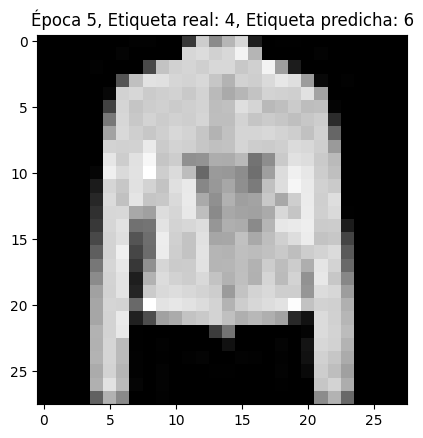

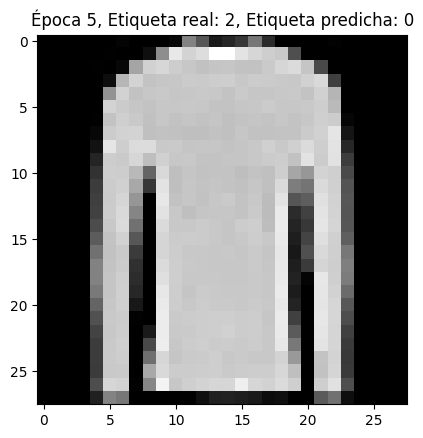

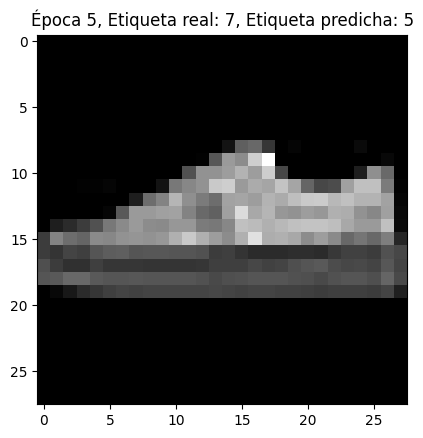

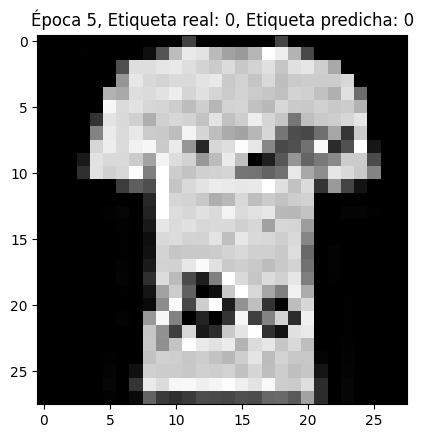

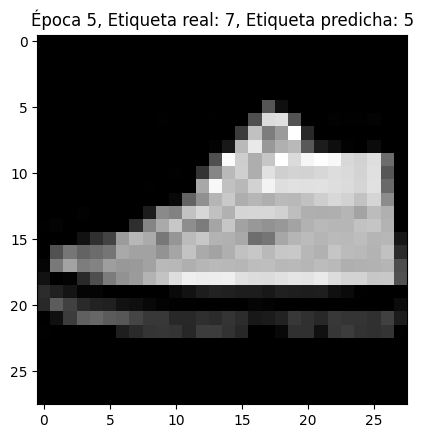

In [ ]:
import numpy as np
import random
import tensorflow.compat.v1 as tf
from tensorflow import keras
import matplotlib.pyplot as plt

tf.disable_v2_behavior()
tf.compat.v1.disable_resource_variables()

# Load training and test data (Fashion MNIST dataset):
dataLoader = keras.datasets.fashion_mnist
(features, labels), (testFeatures, testLabels) = dataLoader.load_data()
onehot_labels = np.zeros((labels.shape[0], 10))
onehot_labels[np.arange(labels.shape[0]), labels] = 1
labels = onehot_labels
features = features
testFeatures = testFeatures
onehot_testLabels = np.zeros((testLabels.shape[0], 10))
onehot_testLabels[np.arange(testLabels.shape[0]), testLabels] = 1
testLabels = onehot_testLabels

# Set the parameters:
NumClasses = 10
BatchLength = 600
Size = [28, 28, 1]
NumIteration = 5
LearningRate = 1e-4
EvalFreq = 1000
NumKernels = [16, 32, 64]

# Spectral pooling size:
#         1/2  - 0
#         6/8 - 1
specPoolSize = 0


def fourier_complex_relu(x):
    real = tf.real(x)
    imag = tf.imag(x)
    return tf.complex(tf.cast(real * real + imag * imag > 0.1, tf.float32) * real,
                      tf.cast(real * real + imag * imag > 0.1, tf.float32) * imag)


def convolution_in_freq_domain_without_ifft(f_input, out_channels):
    in_shape = f_input.get_shape()
    bias_r = tf.get_variable('BiasReal', [out_channels], dtype=tf.float32)
    bias_c = tf.get_variable('BiasComp', [out_channels], dtype=tf.float32)
    bias = tf.complex(bias_r, bias_c)
    # Spectral pooling:
    if specPoolSize == 0:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 4), int(in_shape[2] // 4), 0],
                           [-1, int(in_shape[1] // 2), int(in_shape[2] // 2), in_shape[-1]])
    elif specPoolSize == 1:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 8), int(in_shape[2] // 8), 0],
                           [-1, int(in_shape[1]) - int(2 * in_shape[1] // 8), int(in_shape[2]) - int(2 * in_shape[2] // 8),
                            in_shape[-1]])
    in_shape = f_input.get_shape()
    w_r = tf.get_variable('w_r', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w_i = tf.get_variable('w_i', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w = tf.complex(w_r, w_i)
    fourier_kernel = w
    fourier_kernel = tf.tile(tf.expand_dims(fourier_kernel, 0), [BatchLength, 1, 1, 1, 1])
    out = []
    for ind in range(out_channels):
        res = tf.multiply(f_input[:, :, :, :], fourier_kernel[:, :, :, :, ind])
        res = tf.add(res, bias[ind])
        res = tf.expand_dims(tf.reduce_sum(res, 3), -1)
        out.append(res)
    out = tf.concat(out, 3)  # Con estas líneas utilizando tf.keras.layers.BatchNormalization
    norm_real = tf.keras.layers.BatchNormalization()(tf.real(out), training=True)
    norm_comp = tf.keras.layers.BatchNormalization()(tf.imag(out), training=True)

    out = tf.complex(norm_real, norm_comp)
    out = fourier_complex_relu(out)
    return out


tf.reset_default_graph()
InputData = tf.placeholder(tf.float32, [None] + Size)  # input images
OneHotLabels = tf.placeholder(tf.int32, [None, NumClasses])  # the expected outputs, labels

# Take the input to Fourier domain
CurrentInput = tf.cast(InputData, tf.complex64)
CurrentInput = tf.transpose(CurrentInput, [3, 0, 1, 2])
fourierInput = tf.fft2d(CurrentInput, name=None)
fourierInput = tf.transpose(fourierInput, [1, 2, 3, 0])
fourierInput = tf.roll(fourierInput, shift=[int(Size[0] // 2), int(Size[1] // 2)], axis=[1, 2])
CurrentFilters = Size[-1]

# a loop which creates all layers
for N in range(len(NumKernels)):
    with tf.variable_scope('conv' + str(N)):
        fourierInput = convolution_in_freq_domain_without_ifft(fourierInput, NumKernels[N])

with tf.variable_scope('FC'):
    fourierInput = tf.square(tf.real(fourierInput)) + tf.square(tf.imag(fourierInput))
    CurrentShape = fourierInput.get_shape()
    FeatureLength = int(CurrentShape[1] * CurrentShape[2] * CurrentShape[3])
    FC = tf.reshape(fourierInput, [-1, FeatureLength])
    W = tf.get_variable('W', [FeatureLength, NumClasses])
    FC = tf.matmul(FC, W)
    Bias = tf.get_variable('Bias', [NumClasses])
    FC = tf.add(FC, Bias)

with tf.name_scope('loss'):
    Loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=OneHotLabels, logits=FC))

with tf.name_scope('optimizer'):
    Optimizer = tf.train.AdamOptimizer(LearningRate).minimize(Loss)

with tf.name_scope('accuracy'):
    CorrectPredictions = tf.equal(tf.argmax(FC, 1), tf.argmax(OneHotLabels, 1))
    Accuracy = tf.reduce_mean(tf.cast(CorrectPredictions, tf.float32))

# Crear listas para almacenar la pérdida y la precisión
loss_history = []
accuracy_history = []

# Dividir conjunto de entrenamiento y conjunto de prueba
split_ratio = 1.0
split_index = int(features.shape[0] * split_ratio)

train_features = features[:split_index]
train_labels = labels[:split_index]

val_features = features[split_index:]
val_labels = labels[split_index:]

# Barajar y dividir conjunto de entrenamiento en lotes
indices = np.arange(train_features.shape[0])
np.random.shuffle(indices)

batches = [indices[i:i + BatchLength] for i in range(0, len(indices), BatchLength)]
Init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.compat.v1.Session(config=config) as Sess:
    Sess.run(Init)
    for epoch in range(1, NumIteration + 1):
        print('epoca')
        for batch_index in batches:
            batch_xs = train_features[batch_index, :]
            batch_ys = train_labels[batch_index, :]
            batch_xs = np.reshape(batch_xs, [BatchLength, 28, 28, 1])
            _, Acc, L = Sess.run([Optimizer, Accuracy, Loss], feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})
            print(L)
            # Agregar pérdida y precisión a las listas
            #loss_history.append(L)
            #accuracy_history.append(Acc)


    # Después de imprimir la forma de la salida
    print("Forma de la salida:", FC.shape)

    # Visualizar algunas imágenes y sus predicciones
    num_visualize = 5  # Puedes ajustar el número de imágenes a visualizar

    # Seleccionar aleatoriamente algunas muestras del conjunto de prueba
    visualize_indices = np.random.choice(testFeatures.shape[0], num_visualize, replace=False)

    # Crear una sesión sin inicializar explícitamente las variables
    for i in visualize_indices:
        # Obtener la imagen y la etiqueta verdadera
        input_image = testFeatures[i, :]
        true_label = testLabels[i, :]

        # Preprocesar la entrada para que sea compatible con la red neuronal
        input_image = np.reshape(input_image, [1] + Size)

        # Obtener la predicción del modelo
        prediction = np.argmax(Sess.run(FC, feed_dict={InputData: input_image}), axis=1)

        # Visualizar la imagen, la etiqueta verdadera y la predicción
        plt.imshow(np.squeeze(input_image), cmap='gray')
        plt.title(f'Época {epoch}, Etiqueta real: {np.argmax(true_label)}, Etiqueta predicha: {prediction[0]}')
        plt.show()
        plt.pause(2)  # Pausa de 2 segundos entre imágenes


In [ ]:
from fastai.vision.all import *

# Load training and test data (MNIST dataset):
path = untar_data(URLs.MNIST)
items = get_image_files(path)
lbls = items.map(lambda x: int(x.parent.name))

# Specify that we want images in grayscale
dls = ImageDataLoaders.from_lists(path, items, lbls, valid_pct=0.2, seed=42, item_tfms=Resize(28), color='grayscale')

# Set the parameters:
NumClasses = 10
NumEpochs = 50
LearningRate = 1e-4
NumKernels = [16, 32, 64]

# Define the model architecture
model = nn.Sequential(
    nn.Conv2d(1, NumKernels[0], kernel_size=1, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(NumKernels[0], NumKernels[1], kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(NumKernels[1], NumKernels[2], kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(NumKernels[2] * 28 * 28, NumClasses)
)

print("Input shape before training:", dls.one_batch()[0].shape)
# Create a learner
learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy, cbs=[BnFreeze])

# Train the model
learn.fit_one_cycle(NumEpochs, lr_max=LearningRate)


In [ ]:
import numpy as np
import random
import tensorflow.compat.v1 as tf
from tensorflow import keras
import matplotlib.pyplot as plt

tf.disable_v2_behavior()
tf.compat.v1.disable_resource_variables()

# Load training and test data (Fashion MNIST dataset):
dataLoader = keras.datasets.fashion_mnist
(features, labels), (testFeatures, testLabels) = dataLoader.load_data()
onehot_labels = np.zeros((labels.shape[0], 10))
onehot_labels[np.arange(labels.shape[0]), labels] = 1
labels = onehot_labels
features = features
testFeatures = testFeatures
onehot_testLabels = np.zeros((testLabels.shape[0], 10))
onehot_testLabels[np.arange(testLabels.shape[0]), testLabels] = 1
testLabels = onehot_testLabels

# Set the parameters:
NumClasses = 10
BatchLength = 16
Size = [28, 28, 1]
NumIteration = 100
LearningRate = 1e-4
NumKernels = [16, 32, 64]

# Spectral pooling size:
#         1/2  - 0
#         6/8 - 1
specPoolSize = 0


def fourier_complex_relu(x):
    real = tf.real(x)
    imag = tf.imag(x)
    return tf.complex(tf.cast(real * real + imag * imag > 0.1, tf.float32) * real,
                      tf.cast(real * real + imag * imag > 0.1, tf.float32) * imag)


def convolution_in_freq_domain_without_ifft(f_input, out_channels):
    in_shape = f_input.get_shape()
    bias_r = tf.get_variable('BiasReal', [out_channels], dtype=tf.float32)
    bias_c = tf.get_variable('BiasComp', [out_channels], dtype=tf.float32)
    bias = tf.complex(bias_r, bias_c)
    # Spectral pooling:
    if specPoolSize == 0:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 4), int(in_shape[2] // 4), 0],
                           [-1, int(in_shape[1] // 2), int(in_shape[2] // 2), in_shape[-1]])
    elif specPoolSize == 1:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 8), int(in_shape[2] // 8), 0],
                           [-1, int(in_shape[1]) - int(2 * in_shape[1] // 8), int(in_shape[2]) - int(2 * in_shape[2] // 8),
                            in_shape[-1]])
    in_shape = f_input.get_shape()
    w_r = tf.get_variable('w_r', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w_i = tf.get_variable('w_i', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w = tf.complex(w_r, w_i)
    fourier_kernel = w
    fourier_kernel = tf.tile(tf.expand_dims(fourier_kernel, 0), [BatchLength, 1, 1, 1, 1])
    out = []
    for ind in range(out_channels):
        res = tf.multiply(f_input[:, :, :, :], fourier_kernel[:, :, :, :, ind])
        res = tf.add(res, bias[ind])
        res = tf.expand_dims(tf.reduce_sum(res, 3), -1)
        out.append(res)
    out = tf.concat(out, 3)  # Con estas líneas utilizando tf.keras.layers.BatchNormalization
    norm_real = tf.keras.layers.BatchNormalization()(tf.real(out), training=True)
    norm_comp = tf.keras.layers.BatchNormalization()(tf.imag(out), training=True)

    out = tf.complex(norm_real, norm_comp)
    out = fourier_complex_relu(out)
    return out


tf.reset_default_graph()
InputData = tf.placeholder(tf.float32, [None] + Size)  # input images
OneHotLabels = tf.placeholder(tf.int32, [None, NumClasses])  # the expected outputs, labels

# Take the input to Fourier domain
CurrentInput = tf.cast(InputData, tf.complex64)
CurrentInput = tf.transpose(CurrentInput, [3, 0, 1, 2])
fourierInput = tf.fft2d(CurrentInput, name=None)
fourierInput = tf.transpose(fourierInput, [1, 2, 3, 0])
fourierInput = tf.roll(fourierInput, shift=[int(Size[0] // 2), int(Size[1] // 2)], axis=[1, 2])
CurrentFilters = Size[-1]

# a loop which creates all layers
for N in range(len(NumKernels)):
    with tf.variable_scope('conv' + str(N)):
        fourierInput = convolution_in_freq_domain_without_ifft(fourierInput, NumKernels[N])

with tf.variable_scope('FC'):
    fourierInput = tf.square(tf.real(fourierInput)) + tf.square(tf.imag(fourierInput))
    CurrentShape = fourierInput.get_shape()
    FeatureLength = int(CurrentShape[1] * CurrentShape[2] * CurrentShape[3])
    FC = tf.reshape(fourierInput, [-1, FeatureLength])
    W = tf.get_variable('W', [FeatureLength, NumClasses])
    FC = tf.matmul(FC, W)
    Bias = tf.get_variable('Bias', [NumClasses])
    FC = tf.add(FC, Bias)

with tf.name_scope('loss'):
    Loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=OneHotLabels, logits=FC))

with tf.name_scope('optimizer'):
    Optimizer = tf.train.AdamOptimizer(LearningRate).minimize(Loss)

with tf.name_scope('accuracy'):
    CorrectPredictions = tf.equal(tf.argmax(FC, 1), tf.argmax(OneHotLabels, 1))
    Accuracy = tf.reduce_mean(tf.cast(CorrectPredictions, tf.float32))

# Crear listas para almacenar la pérdida y la precisión
loss_history = []
accuracy_history = []

# Dividir conjunto de entrenamiento y conjunto de prueba
split_ratio = 1.0
split_index = int(features.shape[0] * split_ratio)

train_features = features[:split_index]
train_labels = labels[:split_index]

val_features = features[split_index:]
val_labels = labels[split_index:]

# Barajar y dividir conjunto de entrenamiento en lotes
indices = np.arange(train_features.shape[0])
np.random.shuffle(indices)

batches = [indices[i:i + BatchLength] for i in range(0, len(indices), BatchLength)]
Init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
average_loss_history = []
average_accuracy_history = []

with tf.compat.v1.Session(config=config) as Sess:
    Sess.run(Init)
    for epoch in range(1, NumIteration + 1):
        print(f'Época {epoch}')
        epoch_losses = []
        epoch_accuracies = []

        for batch_index in batches:
            batch_xs = train_features[batch_index, :]
            batch_ys = train_labels[batch_index, :]
            batch_xs = np.reshape(batch_xs, [BatchLength, 28, 28, 1])
            _, Acc, L = Sess.run([Optimizer, Accuracy, Loss], feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})

            epoch_losses.append(L)
            epoch_accuracies.append(Acc)

        # Calcular la pérdida y precisión promedio de la época
        average_loss = np.mean(epoch_losses)
        average_accuracy = np.mean(epoch_accuracies)

        # Agregar la pérdida y precisión promedio a las listas
        average_loss_history.append(average_loss)
        average_accuracy_history.append(average_accuracy)

        print(f'Pérdida promedio: {average_loss}, Precisión promedio: {average_accuracy}')

    # Después de imprimir la forma de la salida
    print("Forma de la salida:", FC.shape)

    # Visualizar algunas imágenes y sus predicciones
    num_visualize = 5  # Puedes ajustar el número de imágenes a visualizar

    # Seleccionar aleatoriamente algunas muestras del conjunto de prueba
    visualize_indices = np.random.choice(testFeatures.shape[0], num_visualize, replace=False)

    # Crear una sesión sin inicializar explícitamente las variables
    for i in visualize_indices:
        # Obtener la imagen y la etiqueta verdadera
        input_image = testFeatures[i, :]
        true_label = testLabels[i, :]

        # Preprocesar la entrada para que sea compatible con la red neuronal
        input_image = np.reshape(input_image, [1] + Size)

        # Obtener la predicción del modelo
        prediction = np.argmax(Sess.run(FC, feed_dict={InputData: input_image}), axis=1)

        # Visualizar la imagen, la etiqueta verdadera y la predicción
        plt.imshow(np.squeeze(input_image), cmap='gray')
        plt.title(f'Época {epoch}, Etiqueta real: {np.argmax(true_label)}, Etiqueta predicha: {prediction[0]}')
        plt.show()
        plt.pause(2)  # Pausa de 2 segundos entre imágenes

# Graficar la pérdida promedio
plt.plot(average_loss_history, label='Pérdida promedio')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida promedio a lo largo de las épocas')
plt.legend()
plt.show()

# Graficar la precisión promedio
plt.plot(average_accuracy_history, label='Precisión promedio')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('Precisión promedio a lo largo de las épocas')
plt.legend()
plt.show()

In [ ]:
def contar_lineas(valores):
    # Convertir la lista a un string separado por saltos de línea
    texto = '\n'.join(map(str, valores)) + '\n'

    # Contar las líneas
    num_lineas = texto.count('\n')

    return num_lineas

# Ejemplo de uso con tus valores
valores = [9.540982, 8.155752, 7.055095, 6.336835, 5.3736587, 4.5594854, 4.7140155, 3.767756, 3.6599443, 3.762139, 3.7850187, 3.1073523, 2.9138782, 3.0609174, 2.7848418, 2.6659322, 2.7153106, 2.3743618, 2.4914336, 2.6024747, 2.3936877, 2.3276732, 2.2821746, 2.0088394, 2.160755, 2.0857751, 1.8749845, 1.8946271, 1.9380292, 1.819306, 1.6819072, 1.8382353, 1.9084914, 1.8359896, 1.7126998, 1.7307271, 1.5054727, 1.646821, 1.7646761, 1.5566751, 1.6523188, 1.4828776, 1.691987, 1.521975, 1.6208559, 1.5815318, 1.483817, 1.5174702, 1.5009061, 1.4264516, 1.4418052, 1.4222277, 1.434852, 1.4692857, 1.4074576, 1.3624986, 1.3002504, 1.4389503, 1.3624806, 1.1947379, 1.2684426, 1.3380628, 1.1813629, 1.2327591, 1.2936959, 1.3103353, 1.3385298, 1.363852, 1.3163258, 1.2367759, 1.2169598, 1.2463655, 1.2440968, 1.238381, 1.2291158, 1.2619476, 1.146483, 1.1771798, 1.1820167, 1.2272276, 1.1029077, 1.1087105, 1.2718396, 1.1830235, 1.1386796, 1.0711523, 1.0777953, 1.1495268, 1.2176257, 1.1443512, 1.0929736, 1.1676915, 1.1236145, 1.1328532, 1.1746216, 1.1400272, 1.077488, 1.1526265, 1.1158648, 1.1355261]

# Contar líneas
num_lineas = contar_lineas(valores)

print(f'El número de líneas es: {num_lineas}')


# DIGITOS CON EPOCAS

Epoch 1
Average Loss: 0.8254676461219788, Average Accuracy: 0.76131671667099
Epoch 2
Average Loss: 0.5419736504554749, Average Accuracy: 0.8398833870887756
Epoch 3
Average Loss: 0.512677013874054, Average Accuracy: 0.8491666913032532
Epoch 4
Average Loss: 0.49547868967056274, Average Accuracy: 0.854283332824707
Epoch 5
Average Loss: 0.48399585485458374, Average Accuracy: 0.8577166795730591
Epoch 6
Average Loss: 0.4742108881473541, Average Accuracy: 0.860966682434082
Epoch 7
Average Loss: 0.4661261737346649, Average Accuracy: 0.8640666604042053
Epoch 8
Average Loss: 0.4603353440761566, Average Accuracy: 0.8659834265708923
Epoch 9
Average Loss: 0.4540346562862396, Average Accuracy: 0.8674499988555908
Epoch 10
Average Loss: 0.44891470670700073, Average Accuracy: 0.8687499761581421
Epoch 11
Average Loss: 0.4440022110939026, Average Accuracy: 0.8703500032424927
Epoch 12
Average Loss: 0.4386233985424042, Average Accuracy: 0.8717166781425476
Epoch 13
Average Loss: 0.43465733528137207, Average

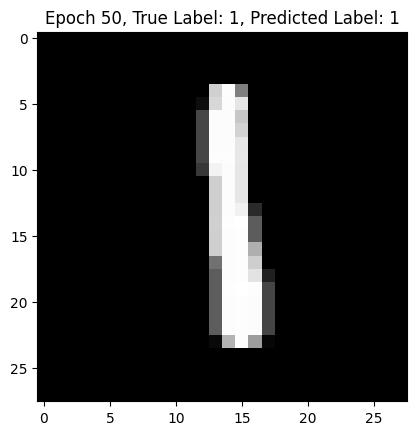

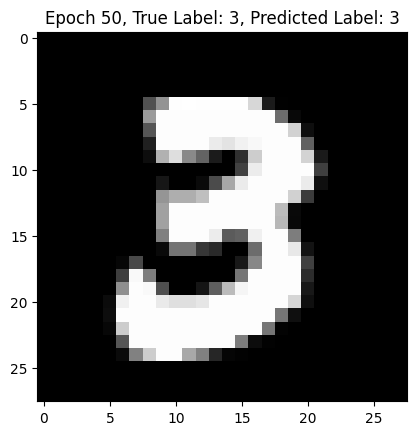

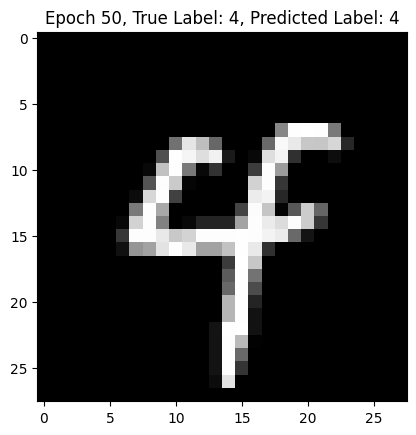

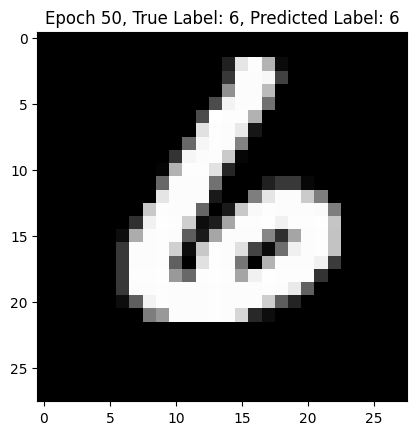

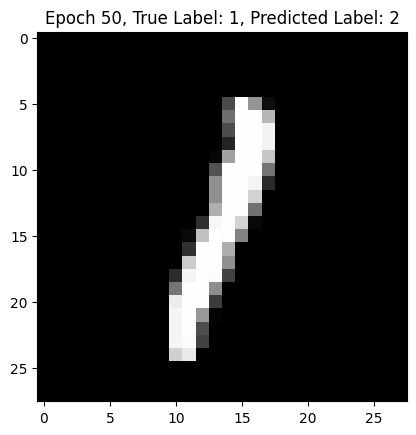

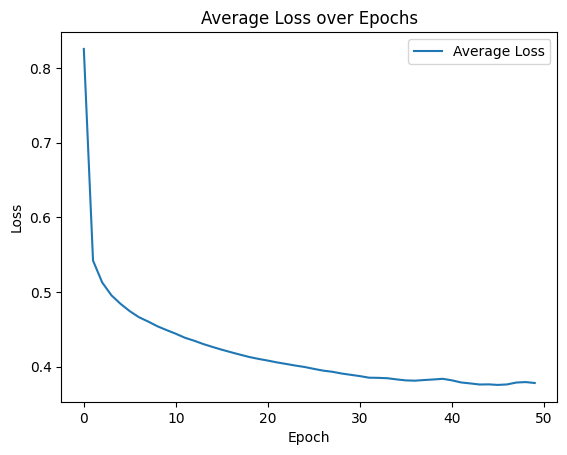

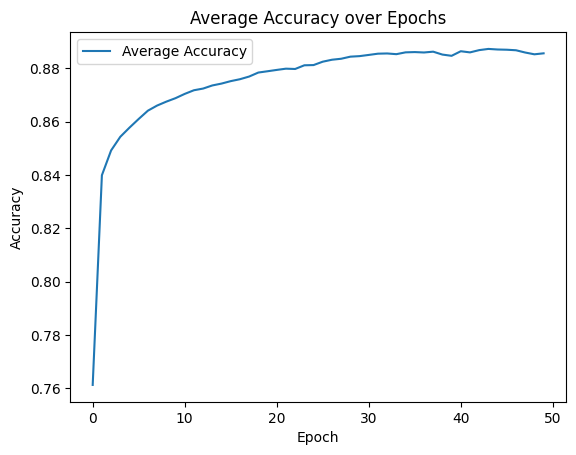

In [ ]:
import numpy as np
import random
import tensorflow.compat.v1 as tf
from tensorflow import keras
import matplotlib.pyplot as plt

tf.disable_v2_behavior()
tf.compat.v1.disable_resource_variables()

# Load training and test data (MNIST dataset):
dataLoader = keras.datasets.mnist
(features, labels), (testFeatures, testLabels) = dataLoader.load_data()
onehot_labels = np.zeros((labels.shape[0], 10))
onehot_labels[np.arange(labels.shape[0]), labels] = 1
labels = onehot_labels
testLabels = keras.utils.to_categorical(testLabels, 10)

# Set the parameters:
NumClasses = 10
BatchLength = 60
Size = [28, 28, 1]
NumIteration = 50
LearningRate = 1e-4                       #Se puede cambiar a 1e-4 IMPORTANTE  DE HECHO QUIZAS MEJOR
NumKernels = [16, 32, 64]

# Spectral pooling size:
#         1/2  - 0
#         6/8 - 1
specPoolSize = 0


def fourier_complex_relu(x):
    real = tf.real(x)
    imag = tf.imag(x)
    return tf.complex(tf.cast(real * real + imag * imag > 0.1, tf.float32) * real,
                      tf.cast(real * real + imag * imag > 0.1, tf.float32) * imag)


def convolution_in_freq_domain_without_ifft(f_input, out_channels):
    in_shape = f_input.get_shape()
    bias_r = tf.get_variable('BiasReal', [out_channels], dtype=tf.float32)
    bias_c = tf.get_variable('BiasComp', [out_channels], dtype=tf.float32)
    bias = tf.complex(bias_r, bias_c)
    # Spectral pooling:
    if specPoolSize == 0:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 4), int(in_shape[2] // 4), 0],
                           [-1, int(in_shape[1] // 2), int(in_shape[2] // 2), in_shape[-1]])
    elif specPoolSize == 1:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 8), int(in_shape[2] // 8), 0],
                           [-1, int(in_shape[1]) - int(2 * in_shape[1] // 8), int(in_shape[2]) - int(2 * in_shape[2] // 8),
                            in_shape[-1]])
    in_shape = f_input.get_shape()
    w_r = tf.get_variable('w_r', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w_i = tf.get_variable('w_i', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w = tf.complex(w_r, w_i)
    fourier_kernel = w
    fourier_kernel = tf.tile(tf.expand_dims(fourier_kernel, 0), [BatchLength, 1, 1, 1, 1])
    out = []
    for ind in range(out_channels):
        res = tf.multiply(f_input[:, :, :, :], fourier_kernel[:, :, :, :, ind])
        res = tf.add(res, bias[ind])
        res = tf.expand_dims(tf.reduce_sum(res, 3), -1)
        out.append(res)
    out = tf.concat(out, 3)
    norm_real = tf.keras.layers.BatchNormalization()(tf.real(out), training=True)
    norm_comp = tf.keras.layers.BatchNormalization()(tf.imag(out), training=True)

    out = tf.complex(norm_real, norm_comp)
    out = fourier_complex_relu(out)
    return out


tf.reset_default_graph()
InputData = tf.placeholder(tf.float32, [None] + Size)  # input images
OneHotLabels = tf.placeholder(tf.float32, [None, NumClasses])  # the expected outputs, labels

# Take the input to Fourier domain
CurrentInput = tf.cast(InputData, tf.complex64)
CurrentInput = tf.transpose(CurrentInput, [3, 0, 1, 2])
fourierInput = tf.fft2d(CurrentInput, name=None)
fourierInput = tf.transpose(fourierInput, [1, 2, 3, 0])
fourierInput = tf.roll(fourierInput, shift=[int(Size[0] // 2), int(Size[1] // 2)], axis=[1, 2])
CurrentFilters = Size[-1]

# a loop which creates all layers
for N in range(len(NumKernels)):
    with tf.variable_scope('conv' + str(N)):
        fourierInput = convolution_in_freq_domain_without_ifft(fourierInput, NumKernels[N])

with tf.variable_scope('FC'):
    fourierInput = tf.square(tf.real(fourierInput)) + tf.square(tf.imag(fourierInput))
    CurrentShape = fourierInput.get_shape()
    FeatureLength = int(CurrentShape[1] * CurrentShape[2] * CurrentShape[3])
    FC = tf.reshape(fourierInput, [-1, FeatureLength])
    W = tf.get_variable('W', [FeatureLength, NumClasses])
    FC = tf.matmul(FC, W)
    Bias = tf.get_variable('Bias', [NumClasses])
    FC = tf.add(FC, Bias)

with tf.name_scope('loss'):
    Loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=OneHotLabels, logits=FC))

with tf.name_scope('optimizer'):
    Optimizer = tf.train.AdamOptimizer(LearningRate).minimize(Loss)

with tf.name_scope('accuracy'):
    CorrectPredictions = tf.equal(tf.argmax(FC, 1), tf.argmax(OneHotLabels, 1))
    Accuracy = tf.reduce_mean(tf.cast(CorrectPredictions, tf.float32))

# Create lists to store loss and accuracy
loss_history = []
accuracy_history = []

# Split training and test sets
split_ratio = 1.0
split_index = int(features.shape[0] * split_ratio)

train_features = features[:split_index]
train_labels = labels[:split_index]

val_features = features[split_index:]
val_labels = labels[split_index:]

# Shuffle and divide training set into batches
indices = np.arange(train_features.shape[0])
np.random.shuffle(indices)

batches = [indices[i:i + BatchLength] for i in range(0, len(indices), BatchLength)]
Init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
average_loss_history = []
average_accuracy_history = []


with tf.compat.v1.Session(config=config) as Sess:
    Sess.run(Init)
    for epoch in range(1, NumIteration + 1):
        print(f'Epoch {epoch}')
        epoch_losses = []
        epoch_accuracies = []

        for batch_index in batches:
            batch_xs = train_features[batch_index, :]
            batch_ys = train_labels[batch_index, :]
            batch_xs = np.reshape(batch_xs, [BatchLength, 28, 28, 1])
            _, Acc, L = Sess.run([Optimizer, Accuracy, Loss], feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})

            epoch_losses.append(L)
            epoch_accuracies.append(Acc)

        # Calculate average loss and accuracy for the epoch
        average_loss = np.mean(epoch_losses)
        average_accuracy = np.mean(epoch_accuracies)

        # Add average loss and accuracy to the lists
        average_loss_history.append(average_loss)
        average_accuracy_history.append(average_accuracy)
        SumAcc=0
        if (epoch>25):
          for i in range(0, testFeatures.shape[0]):
              batch_xs = testFeatures[i, :]
              batch_ys = testLabels[i, :]
              batch_xs = np.reshape(batch_xs, [1]+Size)
              batch_ys = np.reshape(batch_ys, [1, NumClasses])
              a = Sess.run(Accuracy, feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})
              SumAcc += a
          print("Independent Test set: " + str(float(SumAcc) / testFeatures.shape[0]))


        print(f'Average Loss: {average_loss}, Average Accuracy: {average_accuracy}')

    # After printing the shape of the output
    print("Output Shape:", FC.shape)

    # Visualize some images and their predictions
    num_visualize = 5  # You can adjust the number of images to visualize

    # Randomly select some samples from the test set
    visualize_indices = np.random.choice(testFeatures.shape[0], num_visualize, replace=False)

    # Create a session without explicitly initializing variables
    # Evaluate on the test set

    for i in visualize_indices:
        # Get the image and true label
        input_image = testFeatures[i, :]
        true_label = testLabels[i, :]

        # Preprocess the input to make it compatible with the neural network
        input_image = np.reshape(input_image, [1] + Size)

        # Get the model's prediction
        prediction = np.argmax(Sess.run(FC, feed_dict={InputData: input_image}), axis=1)

        # Visualize the image, true label, and prediction
        plt.imshow(np.squeeze(input_image), cmap='gray')
        plt.title(f'Epoch {epoch}, True Label: {np.argmax(true_label)}, Predicted Label: {prediction[0]}')
        plt.show()
        plt.pause(2)  # 2 seconds pause between images

# Plot average loss
plt.plot(average_loss_history, label='Average Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Loss over Epochs')
plt.legend()
plt.show()

# Plot average accuracy
plt.plot(average_accuracy_history, label='Average Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Average Accuracy over Epochs')
plt.legend()
plt.show()


# VALID

In [ ]:
import numpy as np
import random
import tensorflow.compat.v1 as tf
from tensorflow import keras
import matplotlib.pyplot as plt

tf.disable_v2_behavior()
tf.compat.v1.disable_resource_variables()

# Load training and test data (MNIST dataset):
dataLoader = keras.datasets.mnist
(features, labels), (testFeatures, testLabels) = dataLoader.load_data()
onehot_labels = np.zeros((labels.shape[0], 10))
onehot_labels[np.arange(labels.shape[0]), labels] = 1
labels = onehot_labels
testLabels = keras.utils.to_categorical(testLabels, 10)

# Set the parameters:
NumClasses = 10
BatchLength = 60
Size = [28, 28, 1]
NumIteration = 50
LearningRate = 1e-4
NumKernels = [16, 32, 64]

# Spectral pooling size:
#         1/2  - 0
#         6/8 - 1
specPoolSize = 0


def fourier_complex_relu(x):
    real = tf.real(x)
    imag = tf.imag(x)
    return tf.complex(tf.cast(real * real + imag * imag > 0.1, tf.float32) * real,
                      tf.cast(real * real + imag * imag > 0.1, tf.float32) * imag)


def convolution_in_freq_domain_without_ifft(f_input, out_channels):
    in_shape = f_input.get_shape()
    bias_r = tf.get_variable('BiasReal', [out_channels], dtype=tf.float32)
    bias_c = tf.get_variable('BiasComp', [out_channels], dtype=tf.float32)
    bias = tf.complex(bias_r, bias_c)
    # Spectral pooling:
    if specPoolSize == 0:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 4), int(in_shape[2] // 4), 0],
                           [-1, int(in_shape[1] // 2), int(in_shape[2] // 2), in_shape[-1]])
    elif specPoolSize == 1:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 8), int(in_shape[2] // 8), 0],
                           [-1, int(in_shape[1]) - int(2 * in_shape[1] // 8), int(in_shape[2]) - int(2 * in_shape[2] // 8),
                            in_shape[-1]])
    in_shape = f_input.get_shape()
    w_r = tf.get_variable('w_r', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w_i = tf.get_variable('w_i', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w = tf.complex(w_r, w_i)
    fourier_kernel = w
    fourier_kernel = tf.tile(tf.expand_dims(fourier_kernel, 0), [BatchLength, 1, 1, 1, 1])
    out = []
    for ind in range(out_channels):
        res = tf.multiply(f_input[:, :, :, :], fourier_kernel[:, :, :, :, ind])
        res = tf.add(res, bias[ind])
        res = tf.expand_dims(tf.reduce_sum(res, 3), -1)
        out.append(res)
    out = tf.concat(out, 3)
    norm_real = tf.keras.layers.BatchNormalization()(tf.real(out), training=True)
    norm_comp = tf.keras.layers.BatchNormalization()(tf.imag(out), training=True)

    out = tf.complex(norm_real, norm_comp)
    out = fourier_complex_relu(out)
    return out


tf.reset_default_graph()
InputData = tf.placeholder(tf.float32, [None] + Size)  # input images
OneHotLabels = tf.placeholder(tf.float32, [None, NumClasses])  # the expected outputs, labels
ValInputData = tf.placeholder(tf.float32, [None] + Size)  # input images for validation
ValOneHotLabels = tf.placeholder(tf.float32, [None, NumClasses])  # labels for validation

# Take the input to Fourier domain
CurrentInput = tf.cast(InputData, tf.complex64)
CurrentInput = tf.transpose(CurrentInput, [3, 0, 1, 2])
fourierInput = tf.fft2d(CurrentInput, name=None)
fourierInput = tf.transpose(fourierInput, [1, 2, 3, 0])
fourierInput = tf.roll(fourierInput, shift=[int(Size[0] // 2), int(Size[1] // 2)], axis=[1, 2])
CurrentFilters = Size[-1]

# a loop which creates all layers
for N in range(len(NumKernels)):
    with tf.variable_scope('conv' + str(N)):
        fourierInput = convolution_in_freq_domain_without_ifft(fourierInput, NumKernels[N])

with tf.variable_scope('FC'):
    fourierInput = tf.square(tf.real(fourierInput)) + tf.square(tf.imag(fourierInput))
    CurrentShape = fourierInput.get_shape()
    FeatureLength = int(CurrentShape[1] * CurrentShape[2] * CurrentShape[3])
    FC = tf.reshape(fourierInput, [-1, FeatureLength])
    W = tf.get_variable('W', [FeatureLength, NumClasses])
    FC = tf.matmul(FC, W)
    Bias = tf.get_variable('Bias', [NumClasses])
    FC = tf.add(FC, Bias)

with tf.name_scope('loss'):
    Loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=OneHotLabels, logits=FC))
    ValLoss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=ValOneHotLabels, logits=FC))

with tf.name_scope('optimizer'):
    Optimizer = tf.train.AdamOptimizer(LearningRate).minimize(Loss)

with tf.name_scope('accuracy'):
    CorrectPredictions = tf.equal(tf.argmax(FC, 1), tf.argmax(OneHotLabels, 1))
    Accuracy = tf.reduce_mean(tf.cast(CorrectPredictions, tf.float32))
    ValCorrectPredictions = tf.equal(tf.argmax(FC, 1), tf.argmax(ValOneHotLabels, 1))
    ValAccuracy = tf.reduce_mean(tf.cast(ValCorrectPredictions, tf.float32))

# Create lists to store loss and accuracy
loss_history = []
accuracy_history = []
val_loss_history = []
val_accuracy_history = []

# Split training and test sets
split_ratio = 0.8
split_index = int(features.shape[0] * split_ratio)

train_features = features[:split_index]
train_labels = labels[:split_index]

val_features = features[split_index:]
val_labels = labels[split_index:]

# Shuffle and divide training set into batches
indices = np.arange(train_features.shape[0])
np.random.shuffle(indices)

batches = [indices[i:i + BatchLength] for i in range(0, len(indices), BatchLength)]

# Shuffle and divide validation set into batches
val_indices = np.arange(val_features.shape[0])
np.random.shuffle(val_indices)

val_batches = [val_indices[i:i + BatchLength] for i in range(0, len(val_indices), BatchLength)]

Init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
average_loss_history = []
average_accuracy_history = []


with tf.compat.v1.Session(config=config) as Sess:
    Sess.run(Init)
    for epoch in range(1, NumIteration + 1):
        print(f'Epoch {epoch}')
        epoch_losses = []
        epoch_accuracies = []
        val_losses = []
        val_accuracies = []

        for batch_index in batches:
            batch_xs = train_features[batch_index, :]
            batch_ys = train_labels[batch_index, :]
            batch_xs = np.reshape(batch_xs, [BatchLength, 28, 28, 1])
            _, Acc, L = Sess.run([Optimizer, Accuracy, Loss], feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})

            epoch_losses.append(L)
            epoch_accuracies.append(Acc)

        # Calculate average loss and accuracy for the epoch on training set
        average_loss = np.mean(epoch_losses)
        average_accuracy = np.mean(epoch_accuracies)

        for val_batch_index in val_batches:
            val_batch_xs = val_features[val_batch_index, :]
            val_batch_ys = val_labels[val_batch_index, :]
            val_batch_xs = np.reshape(val_batch_xs, [BatchLength, 28, 28, 1])
            val_Acc, val_L = Sess.run([ValAccuracy, ValLoss], feed_dict={ValInputData: val_batch_xs, ValOneHotLabels: val_batch_ys})

            val_accuracies.append(val_Acc)
            val_losses.append(val_L)

        # Evaluate on validation set
        val_acc = np.mean(val_accuracies)
        val_loss = np.mean(val_losses)

        # Add average loss and accuracy to the lists
        average_loss_history.append(average_loss)
        average_accuracy_history.append(average_accuracy)
        val_loss_history.append(val_loss)
        val_accuracy_history.append(val_acc)

        print(f'Average Loss: {average_loss}, Average Accuracy: {average_accuracy}')
        print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')


# Plot average loss y loss de validación
plt.plot(average_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss over Epochs')
plt.legend()
plt.show()

# Plot average accuracy y accuracy de validación
plt.plot(average_accuracy_history, label='Train Accuracy')
plt.plot(val_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy over Epochs')
plt.legend()
plt.show()


 # LEARNING RATE


In [ ]:
import numpy as np
import random
import tensorflow.compat.v1 as tf
from tensorflow import keras
import matplotlib.pyplot as plt

tf.disable_v2_behavior()
tf.compat.v1.disable_resource_variables()

# Load training and test data (MNIST dataset):
dataLoader = keras.datasets.mnist
(features, labels), (testFeatures, testLabels) = dataLoader.load_data()
onehot_labels = np.zeros((labels.shape[0], 10))
onehot_labels[np.arange(labels.shape[0]), labels] = 1
labels = onehot_labels
testLabels = keras.utils.to_categorical(testLabels, 10)

# Set the parameters:
NumClasses = 10
BatchLength = 60
Size = [28, 28, 1]
NumIteration = 50
LearningRate = 1e-6
NumKernels = [16, 32, 64]

# Spectral pooling size:
#         1/2  - 0
#         6/8 - 1
specPoolSize = 0


def fourier_complex_relu(x):
    real = tf.real(x)
    imag = tf.imag(x)
    return tf.complex(tf.cast(real * real + imag * imag > 0.1, tf.float32) * real,
                      tf.cast(real * real + imag * imag > 0.1, tf.float32) * imag)


def convolution_in_freq_domain_without_ifft(f_input, out_channels):
    in_shape = f_input.get_shape()
    bias_r = tf.get_variable('BiasReal', [out_channels], dtype=tf.float32)
    bias_c = tf.get_variable('BiasComp', [out_channels], dtype=tf.float32)
    bias = tf.complex(bias_r, bias_c)
    # Spectral pooling:
    if specPoolSize == 0:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 4), int(in_shape[2] // 4), 0],
                           [-1, int(in_shape[1] // 2), int(in_shape[2] // 2), in_shape[-1]])
    elif specPoolSize == 1:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 8), int(in_shape[2] // 8), 0],
                           [-1, int(in_shape[1]) - int(2 * in_shape[1] // 8), int(in_shape[2]) - int(2 * in_shape[2] // 8),
                            in_shape[-1]])
    in_shape = f_input.get_shape()
    w_r = tf.get_variable('w_r', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w_i = tf.get_variable('w_i', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w = tf.complex(w_r, w_i)
    fourier_kernel = w
    fourier_kernel = tf.tile(tf.expand_dims(fourier_kernel, 0), [BatchLength, 1, 1, 1, 1])
    out = []
    for ind in range(out_channels):
        res = tf.multiply(f_input[:, :, :, :], fourier_kernel[:, :, :, :, ind])
        res = tf.add(res, bias[ind])
        res = tf.expand_dims(tf.reduce_sum(res, 3), -1)
        out.append(res)
    out = tf.concat(out, 3)
    norm_real = tf.keras.layers.BatchNormalization()(tf.real(out), training=True)
    norm_comp = tf.keras.layers.BatchNormalization()(tf.imag(out), training=True)

    out = tf.complex(norm_real, norm_comp)
    out = fourier_complex_relu(out)
    return out


def find_valley(sess, optimizer, loss, input_data, one_hot_labels, learning_rate, start_lr=1e-10, end_lr=1e1, num_batches=100, beta=0.98):
    lr_schedule = np.geomspace(start_lr, end_lr, num=num_batches)
    losses = []
    avg_loss = 0.0

    for i in range(num_batches):
        # Genera un lote aleatorio (puedes ajustar esta parte según tus datos)
        batch_xs = np.random.randn(BatchLength, 28, 28, 1)
        batch_ys = np.random.randn(BatchLength, NumClasses)

        lr = lr_schedule[i]
        _, current_loss = sess.run([optimizer, loss], feed_dict={input_data: batch_xs, one_hot_labels: batch_ys, learning_rate: lr})
        avg_loss = beta * avg_loss + (1 - beta) * current_loss
        smoothed_loss = avg_loss / (1 - beta**(i + 1))
        losses.append(smoothed_loss)

    # Encuentra el "valle" en lugar del mínimo
    derivatives = np.gradient(losses)
    valley_index = np.argmax(derivatives < 0)  # Encuentra el índice donde la derivada es negativa

    return lr_schedule, losses, valley_index


tf.reset_default_graph()
InputData = tf.placeholder(tf.float32, [None] + Size)  # input images
OneHotLabels = tf.placeholder(tf.float32, [None, NumClasses])  # the expected outputs, labels
learning_rate_ph = tf.placeholder(tf.float32, shape=[])

# Take the input to Fourier domain
CurrentInput = tf.cast(InputData, tf.complex64)
CurrentInput = tf.transpose(CurrentInput, [3, 0, 1, 2])
fourierInput = tf.fft2d(CurrentInput, name=None)
fourierInput = tf.transpose(fourierInput, [1, 2, 3, 0])
fourierInput = tf.roll(fourierInput, shift=[int(Size[0] // 2), int(Size[1] // 2)], axis=[1, 2])
CurrentFilters = Size[-1]

# a loop which creates all layers
for N in range(len(NumKernels)):
    with tf.variable_scope('conv' + str(N)):
        fourierInput = convolution_in_freq_domain_without_ifft(fourierInput, NumKernels[N])

with tf.variable_scope('FC'):
    fourierInput = tf.square(tf.real(fourierInput)) + tf.square(tf.imag(fourierInput))
    CurrentShape = fourierInput.get_shape()
    FeatureLength = int(CurrentShape[1] * CurrentShape[2] * CurrentShape[3])
    FC = tf.reshape(fourierInput, [-1, FeatureLength])
    W = tf.get_variable('W', [FeatureLength, NumClasses])
    FC = tf.matmul(FC, W)
    Bias = tf.get_variable('Bias', [NumClasses])
    FC = tf.add(FC, Bias)

with tf.name_scope('loss'):
    Loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=OneHotLabels, logits=FC))

with tf.name_scope('optimizer'):
    Optimizer = tf.train.AdamOptimizer(learning_rate_ph).minimize(Loss)

with tf.name_scope('accuracy'):
    CorrectPredictions = tf.equal(tf.argmax(FC, 1), tf.argmax(OneHotLabels, 1))
    Accuracy = tf.reduce_mean(tf.cast(CorrectPredictions, tf.float32))

# Create lists to store loss and accuracy
loss_history = []
accuracy_history = []

# Split training and test sets
split_ratio = 1.0
split_index = int(features.shape[0] * split_ratio)

train_features = features[:split_index]
train_labels = labels[:split_index]

val_features = features[split_index:]
val_labels = labels[split_index:]

# Shuffle and divide training set into batches
indices = np.arange(train_features.shape[0])
np.random.shuffle(indices)

batches = [indices[i:i + BatchLength] for i in range(0, len(indices), BatchLength)]
Init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
average_loss_history = []
average_accuracy_history = []

with tf.compat.v1.Session(config=config) as Sess:
    Sess.run(Init)

    # Encontrar la tasa de aprendizaje óptima (valle)
    lr_schedule, losses, valley_index = find_valley(Sess, Optimizer, Loss, InputData, OneHotLabels, learning_rate_ph)

    # Visualizar la pérdida en función de la tasa de aprendizaje
    plt.plot(lr_schedule, losses)
    plt.scatter(lr_schedule[valley_index], losses[valley_index], color='red')  # Marca el punto en el "valle"
    plt.xscale('log')
    plt.xlabel('Learning Rate')
    plt.ylabel('Smoothed Loss')
    plt.title('Learning Rate Finder')
    plt.show()

    # Usar la tasa de aprendizaje en el "valle"
    optimal_lr = lr_schedule[valley_index]

    print(f'Optimal Learning Rate (Valley): {optimal_lr}')

    # Entrenar el modelo con la tasa de aprendizaje óptima (valle)
    for epoch in range(1, NumIteration + 1):
        print(f'Epoch {epoch}')
        epoch_losses = []
        epoch_accuracies = []

        for batch_index in batches:
            batch_xs = train_features[batch_index, :]
            batch_ys = train_labels[batch_index, :]
            batch_xs = np.reshape(batch_xs, [BatchLength, 28, 28, 1])
            _, Acc, L = Sess.run([Optimizer, Accuracy, Loss], feed_dict={InputData: batch_xs, OneHotLabels: batch_ys, learning_rate_ph: optimal_lr})

            epoch_losses.append(L)
            epoch_accuracies.append(Acc)

        # Calculate average loss and accuracy for the epoch
        average_loss = np.mean(epoch_losses)
        average_accuracy = np.mean(epoch_accuracies)

        # Add average loss and accuracy to the lists
        average_loss_history.append(average_loss)
        average_accuracy_history.append(average_accuracy)

        print(f'Average Loss: {average_loss}, Average Accuracy: {average_accuracy}')

    # After printing the shape of the output
    print("Output Shape:", FC.shape)

    # Visualize some images and their predictions
    num_visualize = 5  # You can adjust the number of images to visualize

    # Randomly select some samples from the test set
    visualize_indices = np.random.choice(testFeatures.shape[0], num_visualize, replace=False)

    # Create a session without explicitly initializing variables
    for i in visualize_indices:
        # Get the image and true label
        input_image = testFeatures[i, :]
        true_label = testLabels[i, :]

        # Preprocess the input to make it compatible with the neural network
        input_image = np.reshape(input_image, [1] + Size)

        # Get the model's prediction
        prediction = np.argmax(Sess.run(FC, feed_dict={InputData: input_image}), axis=1)

        # Visualize the image, true label, and prediction
        plt.imshow(np.squeeze(input_image), cmap='gray')
        plt.title(f'Epoch {epoch}, True Label: {np.argmax(true_label)}, Predicted Label: {prediction[0]}')
        plt.show()
        plt.pause(2)  # 2 seconds pause between images

# Plot average loss
plt.plot(average_loss_history, label='Average Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Loss over Epochs')
plt.legend()
plt.show()

# Plot average accuracy
plt.plot(average_accuracy_history, label='Average Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Average Accuracy over Epochs')
plt.legend()
plt.show()




# VALID


In [ ]:
import numpy as np
import random
import tensorflow.compat.v1 as tf
from tensorflow import keras
import matplotlib.pyplot as plt

tf.disable_v2_behavior()
tf.compat.v1.disable_resource_variables()

# Load training and test data (MNIST dataset):
dataLoader = keras.datasets.mnist
(features, labels), (testFeatures, testLabels) = dataLoader.load_data()
onehot_labels = np.zeros((labels.shape[0], 10))
onehot_labels[np.arange(labels.shape[0]), labels] = 1
labels = onehot_labels
testLabels = keras.utils.to_categorical(testLabels, 10)

# Set the parameters:
NumClasses = 10
BatchLength = 60
Size = [28, 28, 1]
NumIteration = 50
LearningRate = 1e-4                       #Se puede cambiar a 1e-4 IMPORTANTE  DE HECHO QUIZAS MEJOR
NumKernels = [16, 32, 64]

# Spectral pooling size:
#         1/2  - 0
#         6/8 - 1
specPoolSize = 0


def fourier_complex_relu(x):
    real = tf.real(x)
    imag = tf.imag(x)
    return tf.complex(tf.cast(real * real + imag * imag > 0.1, tf.float32) * real,
                      tf.cast(real * real + imag * imag > 0.1, tf.float32) * imag)


def convolution_in_freq_domain_without_ifft(f_input, out_channels):
    in_shape = f_input.get_shape()
    bias_r = tf.get_variable('BiasReal', [out_channels], dtype=tf.float32)
    bias_c = tf.get_variable('BiasComp', [out_channels], dtype=tf.float32)
    bias = tf.complex(bias_r, bias_c)
    # Spectral pooling:
    if specPoolSize == 0:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 4), int(in_shape[2] // 4), 0],
                           [-1, int(in_shape[1] // 2), int(in_shape[2] // 2), in_shape[-1]])
    elif specPoolSize == 1:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 8), int(in_shape[2] // 8), 0],
                           [-1, int(in_shape[1]) - int(2 * in_shape[1] // 8), int(in_shape[2]) - int(2 * in_shape[2] // 8),
                            in_shape[-1]])
    in_shape = f_input.get_shape()
    w_r = tf.get_variable('w_r', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w_i = tf.get_variable('w_i', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w = tf.complex(w_r, w_i)
    fourier_kernel = w
    fourier_kernel = tf.tile(tf.expand_dims(fourier_kernel, 0), [BatchLength, 1, 1, 1, 1])
    out = []
    for ind in range(out_channels):
        res = tf.multiply(f_input[:, :, :, :], fourier_kernel[:, :, :, :, ind])
        res = tf.add(res, bias[ind])
        res = tf.expand_dims(tf.reduce_sum(res, 3), -1)
        out.append(res)
    out = tf.concat(out, 3)
    norm_real = tf.keras.layers.BatchNormalization()(tf.real(out), training=True)
    norm_comp = tf.keras.layers.BatchNormalization()(tf.imag(out), training=True)

    out = tf.complex(norm_real, norm_comp)
    out = fourier_complex_relu(out)
    return out


tf.reset_default_graph()
InputData = tf.placeholder(tf.float32, [None] + Size)  # input images
OneHotLabels = tf.placeholder(tf.float32, [None, NumClasses])  # the expected outputs, labels

# Take the input to Fourier domain
CurrentInput = tf.cast(InputData, tf.complex64)
CurrentInput = tf.transpose(CurrentInput, [3, 0, 1, 2])
fourierInput = tf.fft2d(CurrentInput, name=None)
fourierInput = tf.transpose(fourierInput, [1, 2, 3, 0])
fourierInput = tf.roll(fourierInput, shift=[int(Size[0] // 2), int(Size[1] // 2)], axis=[1, 2])
CurrentFilters = Size[-1]

# a loop which creates all layers
for N in range(len(NumKernels)):
    with tf.variable_scope('conv' + str(N)):
        fourierInput = convolution_in_freq_domain_without_ifft(fourierInput, NumKernels[N])

with tf.variable_scope('FC'):
    fourierInput = tf.square(tf.real(fourierInput)) + tf.square(tf.imag(fourierInput))
    CurrentShape = fourierInput.get_shape()
    FeatureLength = int(CurrentShape[1] * CurrentShape[2] * CurrentShape[3])
    FC = tf.reshape(fourierInput, [-1, FeatureLength])
    W = tf.get_variable('W', [FeatureLength, NumClasses])
    FC = tf.matmul(FC, W)
    Bias = tf.get_variable('Bias', [NumClasses])
    FC = tf.add(FC, Bias)

with tf.name_scope('loss'):
    Loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=OneHotLabels, logits=FC))

with tf.name_scope('optimizer'):
    Optimizer = tf.train.AdamOptimizer(LearningRate).minimize(Loss)

with tf.name_scope('accuracy'):
    CorrectPredictions = tf.equal(tf.argmax(FC, 1), tf.argmax(OneHotLabels, 1))
    Accuracy = tf.reduce_mean(tf.cast(CorrectPredictions, tf.float32))

# Create lists to store loss and accuracy
loss_history = []
accuracy_history = []

# Split training and test sets
split_ratio = 0.8
split_index = int(features.shape[0] * split_ratio)

train_features = features[:split_index]
train_labels = labels[:split_index]

val_features = features[split_index:]
val_labels = labels[split_index:]

# Shuffle and divide training set into batches
indices = np.arange(train_features.shape[0])
np.random.shuffle(indices)

batches = [indices[i:i + BatchLength] for i in range(0, len(indices), BatchLength)]
Init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
average_loss_history = []
average_accuracy_history = []


with tf.compat.v1.Session(config=config) as Sess:
    Sess.run(Init)
    for epoch in range(1, NumIteration + 1):
        print(f'Epoch {epoch}')
        epoch_losses = []
        epoch_accuracies = []

        for batch_index in batches:
            batch_xs = train_features[batch_index, :]
            batch_ys = train_labels[batch_index, :]
            batch_xs = np.reshape(batch_xs, [BatchLength, 28, 28, 1])
            _, Acc, L = Sess.run([Optimizer, Accuracy, Loss], feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})

            epoch_losses.append(L)
            epoch_accuracies.append(Acc)

        # Calculate average loss and accuracy for the epoch
        average_loss = np.mean(epoch_losses)
        average_accuracy = np.mean(epoch_accuracies)

        # Add average loss and accuracy to the lists
        average_loss_history.append(average_loss)
        average_accuracy_history.append(average_accuracy)

        print(f'Average Loss: {average_loss}, Average Accuracy: {average_accuracy}')

    # After printing the shape of the output
    print("Output Shape:", FC.shape)

    # Visualize some images and their predictions
    num_visualize = 5  # You can adjust the number of images to visualize

    # Randomly select some samples from the test set
    visualize_indices = np.random.choice(testFeatures.shape[0], num_visualize, replace=False)

    # Create a session without explicitly initializing variables
    # Evaluate on the test set
    test_acc, test_loss = Sess.run([Accuracy, Loss], feed_dict={InputData: testFeatures, OneHotLabels: testLabels})
    print(f'Test Accuracy: {test_acc}, Test Loss: {test_loss}')

    for i in visualize_indices:
        # Get the image and true label
        input_image = testFeatures[i, :]
        true_label = testLabels[i, :]

        # Preprocess the input to make it compatible with the neural network
        input_image = np.reshape(input_image, [1] + Size)

        # Get the model's prediction
        prediction = np.argmax(Sess.run(FC, feed_dict={InputData: input_image}), axis=1)

        # Visualize the image, true label, and prediction
        plt.imshow(np.squeeze(input_image), cmap='gray')
        plt.title(f'Epoch {epoch}, True Label: {np.argmax(true_label)}, Predicted Label: {prediction[0]}')
        plt.show()
        plt.pause(2)  # 2 seconds pause between images

# Plot average loss
plt.plot(average_loss_history, label='Average Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Loss over Epochs')
plt.legend()
plt.show()

# Plot average accuracy
plt.plot(average_accuracy_history, label='Average Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Average Accuracy over Epochs')
plt.legend()
plt.show()


# CONVOLUCIONES DIRECTAS

In [ ]:
from fastai.vision.all import *

# Cargar datos y aplicar la transformación a escala de grises
path = untar_data(URLs.MNIST_TINY)

# Definir el bloque de datos
mnist = DataBlock(blocks=(ImageBlock, CategoryBlock),
                  get_items=get_image_files,
                  splitter=GrandparentSplitter(),
                  get_y=parent_label,
                  item_tfms=Resize(460),
                  batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)])

# Crear el objeto DataLoaders
data = mnist.dataloaders(path)

# Inicializar el modelo y crear el objeto Learner
num_classes = 10
num_kernels = [16, 32, 64]
model = FourierNet(num_classes, num_kernels)
learn = Learner(data, model, metrics=accuracy)

# Entrenar el modelo
learn.fine_tune(50)




In [ ]:

from google.colab import files

uploaded = files.upload()


In [ ]:
import zipfile
import os

zip_path = '/content/archive(1).zip'  # Ajusta la ruta al lugar donde guardaste el archivo zip
extract_path = '/content/'  # Ruta donde deseas extraer los archivos

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from fastai.vision.all import *

path = Path('/content/')  # Ruta a la carpeta que contiene train y test
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   get_y=parent_label,
                   item_tfms=Resize(28),
                   batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)])
dls = dblock.dataloaders(path, bs=64)



In [ ]:
dls.show_batch()


In [ ]:
import os
from pathlib import Path
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Ruta al directorio que contiene el conjunto de datos
data_path = Path('/content/Dataset/')

# Lista de etiquetas disponibles en el conjunto de datos (ajusta según tus clases)
labels = ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]

# Cargar el conjunto de datos
dataLoader = ImageDataGenerator(rescale=1./255)

train_generator = dataLoader.flow_from_directory(
    data_path / 'train',  # Ruta a la carpeta 'train'
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical",
    classes=labels
)

test_generator = dataLoader.flow_from_directory(
    data_path / 'test',   # Ruta a la carpeta 'test'
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical",
    classes=labels
)

# Tamaño de las imágenes y número de clases para tus datos médicos
tu_ancho, tu_alto, tu_canales = 128, 128, 4  # Ajusta según tus necesidades
NumClasses = len(labels)

# Asegúrate de que las etiquetas sean categóricas si es necesario
onehot_train_labels = keras.utils.to_categorical(train_generator.classes, NumClasses)
onehot_test_labels = keras.utils.to_categorical(test_generator.classes, NumClasses)
# Obtener el tamaño de las imágenes desde el generador de entrenamiento
tamaño_imagenes = train_generator.image_shape
print("Tamaño de las imágenes:", tamaño_imagenes)


In [ ]:
import os
from pathlib import Path
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt

tf.disable_v2_behavior()
tf.compat.v1.disable_resource_variables()

# Ruta al directorio que contiene el conjunto de datos
data_path = Path('/content/Dataset/')

# Lista de etiquetas disponibles en el conjunto de datos (ajusta según tus clases)
labels = ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]

# Cargar el conjunto de datos
dataLoader = ImageDataGenerator(rescale=1./255)

# Generador de flujo de entrenamiento
train_generator = dataLoader.flow_from_directory(
    data_path / 'train',
    target_size=(128, 128),
    batch_size=125,
    class_mode="categorical",
    classes=labels
)

# Generador de flujo de prueba
test_generator = dataLoader.flow_from_directory(
    data_path / 'test',
    target_size=(128, 128),
    batch_size=125,
    class_mode="categorical",
    classes=labels
)

# Set the parameters:
NumClasses = 4
BatchLength = 125
Size = [128, 128, 3]  # Asegúrate de que el número de canales coincida con tus imágenes
NumIteration = 40000
LearningRate = 1e-4
NumKernels = [16, 32, 64]

# Spectral pooling size:
#         1/2  - 0
#         6/8 - 1
specPoolSize = 0


def fourier_complex_relu(x):
    real = tf.real(x)
    imag = tf.imag(x)
    return tf.complex(tf.cast(real * real + imag * imag > 0.1, tf.float32) * real,
                      tf.cast(real * real + imag * imag > 0.1, tf.float32) * imag)


def convolution_in_freq_domain_without_ifft(f_input, out_channels):
    in_shape = f_input.get_shape()
    bias_r = tf.get_variable('BiasReal', [out_channels], dtype=tf.float32)
    bias_c = tf.get_variable('BiasComp', [out_channels], dtype=tf.float32)
    bias = tf.complex(bias_r, bias_c)
    # Spectral pooling:
    if specPoolSize == 0:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 4), int(in_shape[2] // 4), 0],
                           [-1, int(in_shape[1] // 2), int(in_shape[2] // 2), in_shape[-1]])
    elif specPoolSize == 1:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 8), int(in_shape[2] // 8), 0],
                           [-1, int(in_shape[1]) - int(2 * in_shape[1] // 8), int(in_shape[2]) - int(2 * in_shape[2] // 8),
                            in_shape[-1]])
    in_shape = f_input.get_shape()
    w_r = tf.get_variable('w_r', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w_i = tf.get_variable('w_i', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w = tf.complex(w_r, w_i)
    fourier_kernel = w
    fourier_kernel = tf.tile(tf.expand_dims(fourier_kernel, 0), [BatchLength, 1, 1, 1, 1])
    out = []
    for ind in range(out_channels):
        res = tf.multiply(f_input[:, :, :, :], fourier_kernel[:, :, :, :, ind])
        res = tf.add(res, bias[ind])
        res = tf.expand_dims(tf.reduce_sum(res, 3), -1)
        out.append(res)
    out = tf.concat(out, 3)
    norm_real = tf.keras.layers.BatchNormalization()(tf.real(out), training=True)
    norm_comp = tf.keras.layers.BatchNormalization()(tf.imag(out), training=True)

    out = tf.complex(norm_real, norm_comp)
    out = fourier_complex_relu(out)
    return out


# Crear el grafo de TensorFlow
tf.reset_default_graph()
InputData = tf.placeholder(tf.float32, [None] + Size)  # Cambiado a float32 para imágenes a color
OneHotLabels = tf.placeholder(tf.float32, [None, NumClasses])

CurrentInput = tf.cast(InputData, tf.complex64)
CurrentInput = tf.transpose(CurrentInput, [3, 0, 1, 2])
fourierInput = tf.fft2d(CurrentInput, name=None)
fourierInput = tf.transpose(fourierInput, [1, 2, 3, 0])
fourierInput = tf.roll(fourierInput, shift=[int(Size[0] // 2), int(Size[1] // 2)], axis=[1, 2])
CurrentFilters = Size[-1]

for N in range(len(NumKernels)):
    with tf.variable_scope('conv' + str(N)):
        fourierInput = convolution_in_freq_domain_without_ifft(fourierInput, NumKernels[N])

with tf.variable_scope('FC'):
    fourierInput = tf.square(tf.real(fourierInput)) + tf.square(tf.imag(fourierInput))
    CurrentShape = fourierInput.get_shape()
    FeatureLength = int(CurrentShape[1] * CurrentShape[2] * CurrentShape[3])
    FC = tf.reshape(fourierInput, [-1, FeatureLength])
    W = tf.get_variable('W', [FeatureLength, NumClasses])
    FC = tf.matmul(FC, W)
    Bias = tf.get_variable('Bias', [NumClasses])
    FC = tf.add(FC, Bias)

with tf.name_scope('loss'):
    Loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=OneHotLabels, logits=FC))

with tf.name_scope('optimizer'):
    Optimizer = tf.train.AdamOptimizer(LearningRate).minimize(Loss)

with tf.name_scope('accuracy'):
    CorrectPredictions = tf.equal(tf.argmax(FC, 1), tf.argmax(OneHotLabels, 1))
    Accuracy = tf.reduce_mean(tf.cast(CorrectPredictions, tf.float32))

# Inicializar variables
Init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Listas para almacenar pérdida y precisión
loss_history = []
accuracy_history = []

# Crear sesión de TensorFlow
with tf.compat.v1.Session(config=config) as Sess:
    Sess.run(Init)

    for epoch in range(1, NumIteration + 1):
        print(f'Epoch {epoch}')

        # Obtener un lote de datos de entrenamiento
        batch_xs, batch_ys = next(train_generator)
        print("Shape of batch_xs before reshaping:", batch_xs.shape)  # Agregado para imprimir la forma antes de remodelar
        # Asegurémonos de que el tamaño del lote coincida con el tamaño de las imágenes
        batch_xs = np.reshape(batch_xs, [BatchLength] + list(Size))
        print("Shape of batch_xs after reshaping:", batch_xs.shape)  # Agregado para imprimir la forma después de remodelar

        # Ejecutar el optimizador y calcular la pérdida y precisión
        _, Acc, L = Sess.run([Optimizer, Accuracy, Loss], feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})

        # Imprimir resultados parciales
        print(f'Loss: {L}, Accuracy: {Acc}')

        # Almacenar pérdida y precisión en las listas
        loss_history.append(L)
        accuracy_history.append(Acc)

    # Después de imprimir la forma de la salida
    print("Output Shape:", FC.shape)

    # Visualizar algunas imágenes y sus predicciones
    num_visualize = 5  # Puedes ajustar el número de imágenes a visualizar

    # Seleccionar aleatoriamente algunas muestras del conjunto de prueba
    visualize_indices = np.random.choice(len(test_generator), num_visualize, replace=False)
    # Evaluar el modelo en el conjunto de prueba
    test_accuracy = 0.0
    test_predictions = []

    num_test_batches = len(test_generator)

    for i in range(num_test_batches):
      test_batch_xs, test_batch_ys = next(test_generator)

      # Calcular la precisión en el lote de prueba
      accuracy, predictions = Sess.run([Accuracy, FC], feed_dict={InputData: test_batch_xs, OneHotLabels: test_batch_ys})
      test_accuracy += accuracy
      test_predictions.extend(predictions)

        # Calcular la precisión promedio en el conjunto de prueba
    test_accuracy /= num_test_batches
    print(f'Test Accuracy: {test_accuracy}')

# Graficar pérdida promedio
plt.plot(loss_history, label='Average Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Loss over Epochs')
plt.legend()
plt.show()

# Graficar precisión promedio
plt.plot(accuracy_history, label='Average Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Average Accuracy over Epochs')
plt.legend()
plt.show()


In [ ]:
import os
from pathlib import Path
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt

tf.disable_v2_behavior()
tf.compat.v1.disable_resource_variables()

# Ruta al directorio que contiene el conjunto de datos
data_path = Path('/content/DataSet/')

# Lista de etiquetas disponibles en el conjunto de datos (ajusta según tus clases)
labels = ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]

# Cargar el conjunto de datos
dataLoader = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generador de flujo de entrenamiento
train_generator = dataLoader.flow_from_directory(
    data_path / 'train',
    target_size=(128, 128),
    batch_size=32,  # Ajusta el tamaño del lote según sea necesario
    class_mode="categorical",
    classes=labels
)

# Generador de flujo de prueba
test_generator = dataLoader.flow_from_directory(
    data_path / 'test',
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical",
    classes=labels
)

# Set the parameters:
NumClasses = 4
BatchLength = 32  # Ajusta el tamaño del lote según sea necesario
Size = [128, 128, 3]  # Asegúrate de que el número de canales coincida con tus imágenes
NumIteration = 60
LearningRate = 1e-4
NumKernels = [2,8,16, 32, 64]

# Spectral pooling size:
#         1/2  - 0
#         6/8 - 1
specPoolSize = 0

def fourier_complex_relu(x):
    real = tf.real(x)
    imag = tf.imag(x)
    return tf.complex(tf.cast(real * real + imag * imag > 0.1, tf.float32) * real,
                      tf.cast(real * real + imag * imag > 0.1, tf.float32) * imag)

def convolution_in_freq_domain_without_ifft(f_input, out_channels):
    in_shape = f_input.get_shape()
    bias_r = tf.get_variable('BiasReal', [out_channels], dtype=tf.float32)
    bias_c = tf.get_variable('BiasComp', [out_channels], dtype=tf.float32)
    bias = tf.complex(bias_r, bias_c)
    # Spectral pooling:
    if specPoolSize == 0:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 4), int(in_shape[2] // 4), 0],
                           [-1, int(in_shape[1] // 2), int(in_shape[2] // 2), in_shape[-1]])
    elif specPoolSize == 1:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 8), int(in_shape[2] // 8), 0],
                           [-1, int(in_shape[1]) - int(2 * in_shape[1] // 8), int(in_shape[2]) - int(2 * in_shape[2] // 8),
                            in_shape[-1]])
    in_shape = f_input.get_shape()
    w_r = tf.get_variable('w_r', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w_i = tf.get_variable('w_i', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w = tf.complex(w_r, w_i)
    print("Size of w:", w.get_shape().as_list())
    fourier_kernel = w
    fourier_kernel = tf.tile(tf.expand_dims(fourier_kernel, 0), [BatchLength, 1, 1, 1, 1])
    out = []
    for ind in range(out_channels):
        res = tf.multiply(f_input[:, :, :, :], fourier_kernel[:, :, :, :, ind])
        res = tf.add(res, bias[ind])
        res = tf.expand_dims(tf.reduce_sum(res, 3), -1)
        out.append(res)
    out = tf.concat(out, 3)
    norm_real = tf.keras.layers.BatchNormalization()(tf.real(out), training=True)
    norm_comp = tf.keras.layers.BatchNormalization()(tf.imag(out), training=True)

    out = tf.complex(norm_real, norm_comp)
    out = fourier_complex_relu(out)
    return out

tf.reset_default_graph()
InputData = tf.placeholder(tf.float32, [None] + Size)  # input images
OneHotLabels = tf.placeholder(tf.float32, [None, NumClasses])  # the expected outputs, labels

# Take the input to Fourier domain
CurrentInput = tf.cast(InputData, tf.complex64)
CurrentInput = tf.transpose(CurrentInput, [3, 0, 1, 2])
fourierInput = tf.fft2d(CurrentInput, name=None)
fourierInput = tf.transpose(fourierInput, [1, 2, 3, 0])
fourierInput = tf.roll(fourierInput, shift=[int(Size[0] // 2), int(Size[1] // 2)], axis=[1, 2])
CurrentFilters = Size[-1]

# a loop which creates all layers
for N in range(len(NumKernels)):
    with tf.variable_scope('conv' + str(N)):
        fourierInput = convolution_in_freq_domain_without_ifft(fourierInput, NumKernels[N])

with tf.variable_scope('FC'):
    fourierInput = tf.square(tf.real(fourierInput)) + tf.square(tf.imag(fourierInput))
    CurrentShape = fourierInput.get_shape()
    FeatureLength = int(CurrentShape[1] * CurrentShape[2] * CurrentShape[3])
    FC = tf.reshape(fourierInput, [-1, FeatureLength])
    W = tf.get_variable('W', [FeatureLength, NumClasses])
    FC = tf.matmul(FC, W)
    Bias = tf.get_variable('Bias', [NumClasses])
    FC = tf.add(FC, Bias)
    # Añadir Dropout
    FC = tf.nn.dropout(FC, keep_prob=0.5)

with tf.variable_scope('FC2'):
    fourierInput = tf.square(tf.real(fourierInput)) + tf.square(tf.imag(fourierInput))
    CurrentShape = fourierInput.get_shape()
    FeatureLength = int(CurrentShape[1] * CurrentShape[2] * CurrentShape[3])
    FC2 = tf.reshape(fourierInput, [-1, FeatureLength])
    W2 = tf.get_variable('W2', [FeatureLength, NumClasses])
    FC2 = tf.matmul(FC2, W2)
    Bias2 = tf.get_variable('Bias2', [NumClasses])
    FC2 = tf.add(FC2, Bias2)
    # Añadir Dropout con la nueva sintaxis
    FC2 = tf.nn.dropout(FC2, rate=1-KeepProb)



with tf.name_scope('loss'):
    Loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=OneHotLabels, logits=FC))

with tf.name_scope('optimizer'):
    Optimizer = tf.train.AdamOptimizer(LearningRate).minimize(Loss)

with tf.name_scope('accuracy'):
    CorrectPredictions = tf.equal(tf.argmax(FC, 1), tf.argmax(OneHotLabels, 1))
    Accuracy = tf.reduce_mean(tf.cast(CorrectPredictions, tf.float32))

# Create lists to store loss and accuracy
loss_history = []
accuracy_history = []

# Split training and validation sets
split_ratio = 0.8  # Ajusta según sea necesario
split_index = int(len(train_generator) * split_ratio)

train_samples = int(split_index * BatchLength)
val_samples = len(train_generator) - train_samples

train_features = train_generator[0][0][:train_samples]
train_labels = train_generator[0][1][:train_samples]

val_features = train_generator[0][0][train_samples:train_samples+val_samples]
val_labels = train_generator[0][1][train_samples:train_samples+val_samples]


# Shuffle and divide training set into batches
indices = np.arange(train_features.shape[0])
np.random.shuffle(indices)

batches = [indices[i:i + BatchLength] for i in range(0, len(indices), BatchLength)]
Init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
average_loss_history = []
average_accuracy_history = []

with tf.compat.v1.Session(config=config) as Sess:
    Sess.run(Init)
    for epoch in range(1, NumIteration + 1):
        print(f'Epoch {epoch}')
        epoch_losses = []
        epoch_accuracies = []

        for batch_index in batches:
            batch_xs = train_features[batch_index, :]
            batch_ys = train_labels[batch_index, :]
            batch_xs = np.reshape(batch_xs, [BatchLength] + Size)
            _, Acc, L = Sess.run([Optimizer, Accuracy, Loss], feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})

            epoch_losses.append(L)
            epoch_accuracies.append(Acc)

        # Calculate average loss and accuracy for the epoch
        average_loss = np.mean(epoch_losses)
        average_accuracy = np.mean(epoch_accuracies)

        # Add average loss and accuracy to the lists
        average_loss_history.append(average_loss)
        average_accuracy_history.append(average_accuracy)

        # Evaluate on validation set
        val_accs = []
        print(f'Average Loss: {average_loss}, Average Accuracy: {average_accuracy}')

    # Visualiza algunas muestras del conjunto de prueba
    num_visualize = min(30, len(test_generator))  # Asegúrate de no exceder la longitud del generador de flujo de prueba

    # Selecciona aleatoriamente algunas muestras del conjunto de prueba
    visualize_indices = np.random.choice(len(test_generator), num_visualize, replace=False)

    for i in visualize_indices:
        # Obtén el lote de imágenes y etiquetas
        input_images, true_labels = test_generator[i]

        # Selecciona solo una imagen del lote (aquí estamos eligiendo la primera)
        input_image = input_images[0]
        true_label = true_labels[0]

        # Asegúrate de que las dimensiones de la imagen sean correctas
        if len(input_image.shape) == 3:
            input_image = np.expand_dims(input_image, axis=0)  # Agrega la dimensión del lote

        # Obtén la predicción del modelo
        prediction = np.argmax(Sess.run(FC, feed_dict={InputData: input_image}), axis=1)

        # Visualiza la imagen, la etiqueta verdadera y la predicción
        plt.imshow(np.squeeze(input_image))
        plt.title(f'True Label: {np.argmax(true_label)}, Predicted Label: {prediction[0]}')
        plt.show()

      # Calcular la precisión en el conjunto de prueba
    test_accs = []

# Inicializar la lista para almacenar las precisiones individuales
# Crear una lista para almacenar las precisiones en el conjunto de prueba

# Calcular la precisión en el conjunto de prueba

    for i in range(len(test_generator)):
        # Obtener el lote de imágenes y etiquetas
        test_images, test_labels = test_generator[i]

        # Calcular la precisión para cada imagen en el lote
        batch_accs = []
        for j in range(test_images.shape[0]):
            image = test_images[j]
            label = test_labels[j]

            # Asegurarse de que las dimensiones de la imagen sean correctas
            if len(image.shape) == 3:
                image = np.expand_dims(image, axis=0)  # Agregar la dimensión del lote

            # Obtener la predicción del modelo
            prediction = np.argmax(Sess.run(FC, feed_dict={InputData: image}), axis=1)

            # Calcular la precisión para esta imagen
            batch_accs.append(prediction[0] == np.argmax(label))

            # Calcular la precisión promedio para el lote actual
            batch_accuracy = np.mean(batch_accs)
            test_accs.append(batch_accuracy)

    # Calcular la precisión global en el conjunto de prueba
    test_accuracy = np.mean(test_accs)
    print("Test Accuracy:", test_accuracy)




Muy malos resultados estaria bien lo del valid

In [ ]:
import os
from pathlib import Path
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt

tf.disable_v2_behavior()
tf.compat.v1.disable_resource_variables()

# Ruta al directorio que contiene el conjunto de datos
data_path = Path('/content/DataSet/')

# Lista de etiquetas disponibles en el conjunto de datos (ajusta según tus clases)
labels = ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]

# Generador de flujo de datos con aumento para entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generador de flujo de entrenamiento
train_generator = train_datagen.flow_from_directory(
    data_path / 'train',
    target_size=(128, 128),
    batch_size=32,  # Ajusta el tamaño del lote según sea necesario
    class_mode="categorical",
    classes=labels
)

# Generador de flujo de prueba sin aumento de datos
test_datagen = ImageDataGenerator(rescale=1./255)

# Generador de flujo de prueba
test_generator = test_datagen.flow_from_directory(
    data_path / 'test',
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical",
    classes=labels
)


# Set the parameters:
NumClasses = 4
BatchLength = 32  # Ajusta el tamaño del lote según sea necesario
Size = [128, 128, 3]  # Asegúrate de que el número de canales coincida con tus imágenes
NumIteration = 40
LearningRate = 1e-4
NumKernels = [2,8,16,32,64]

# Spectral pooling size:
#         1/2  - 0
#         6/8 - 1
specPoolSize = 0

def fourier_complex_relu(x):
    real = tf.real(x)
    imag = tf.imag(x)
    return tf.complex(tf.cast(real * real + imag * imag > 0.1, tf.float32) * real,
                      tf.cast(real * real + imag * imag > 0.1, tf.float32) * imag)

def convolution_in_freq_domain_without_ifft(f_input, out_channels):
    in_shape = f_input.get_shape()
    bias_r = tf.get_variable('BiasReal', [out_channels], dtype=tf.float32)
    bias_c = tf.get_variable('BiasComp', [out_channels], dtype=tf.float32)
    bias = tf.complex(bias_r, bias_c)
    # Spectral pooling:
    if specPoolSize == 0:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 4), int(in_shape[2] // 4), 0],
                           [-1, int(in_shape[1] // 2), int(in_shape[2] // 2), in_shape[-1]])
    elif specPoolSize == 1:
        f_input = tf.slice(f_input, [0, int(in_shape[1] // 8), int(in_shape[2] // 8), 0],
                           [-1, int(in_shape[1]) - int(2 * in_shape[1] // 8), int(in_shape[2]) - int(2 * in_shape[2] // 8),
                            in_shape[-1]])
    in_shape = f_input.get_shape()
    w_r = tf.get_variable('w_r', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w_i = tf.get_variable('w_i', [int(in_shape[1]), int(in_shape[2]), int(in_shape[3]), out_channels])
    w = tf.complex(w_r, w_i)
    print("Size of w:", w.get_shape().as_list())
    fourier_kernel = w
    fourier_kernel = tf.tile(tf.expand_dims(fourier_kernel, 0), [BatchLength, 1, 1, 1, 1])
    out = []
    for ind in range(out_channels):
        res = tf.multiply(f_input[:, :, :, :], fourier_kernel[:, :, :, :, ind])
        res = tf.add(res, bias[ind])
        res = tf.expand_dims(tf.reduce_sum(res, 3), -1)
        out.append(res)
    out = tf.concat(out, 3)
    norm_real = tf.keras.layers.BatchNormalization()(tf.real(out), training=True)
    norm_comp = tf.keras.layers.BatchNormalization()(tf.imag(out), training=True)

    out = tf.complex(norm_real, norm_comp)
    out = fourier_complex_relu(out)
    return out

tf.reset_default_graph()
InputData = tf.placeholder(tf.float32, [None] + Size)  # input images
OneHotLabels = tf.placeholder(tf.float32, [None, NumClasses])  # the expected outputs, labels

# Take the input to Fourier domain
CurrentInput = tf.cast(InputData, tf.complex64)
CurrentInput = tf.transpose(CurrentInput, [3, 0, 1, 2])
fourierInput = tf.fft2d(CurrentInput, name=None)
fourierInput = tf.transpose(fourierInput, [1, 2, 3, 0])
fourierInput = tf.roll(fourierInput, shift=[int(Size[0] // 2), int(Size[1] // 2)], axis=[1, 2])
CurrentFilters = Size[-1]

# a loop which creates all layers
for N in range(len(NumKernels)):
    with tf.variable_scope('conv' + str(N)):
        fourierInput = convolution_in_freq_domain_without_ifft(fourierInput, NumKernels[N])

# ... (código previo)

with tf.variable_scope('FC'):
    fourierInput = tf.square(tf.real(fourierInput)) + tf.square(tf.imag(fourierInput))
    CurrentShape = fourierInput.get_shape()
    FeatureLength = int(CurrentShape[1] * CurrentShape[2] * CurrentShape[3])
    FC = tf.reshape(fourierInput, [-1, FeatureLength])
    W = tf.get_variable('W', [FeatureLength, NumClasses])
    FC = tf.matmul(FC, W)
    Bias = tf.get_variable('Bias', [NumClasses])
    logits = tf.add(FC, Bias)
    # Aplicar softmax complejo por separado en partes real e imaginaria
    real_part_softmax = tf.nn.softmax(tf.real(logits))
    imag_part_softmax = tf.nn.softmax(tf.imag(logits))
    # Combinar las partes real e imaginaria de nuevo en un tensor complejo
    probabilities_complex = tf.complex(real_part_softmax, imag_part_softmax)
    # Puedes utilizar la función tf.abs para obtener la magnitud de las probabilidades
    probabilities_magnitude = tf.abs(probabilities_complex)



with tf.name_scope('loss'):
    Loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=OneHotLabels, logits=logits))

with tf.name_scope('optimizer'):
    Optimizer = tf.train.AdamOptimizer(LearningRate).minimize(Loss)

with tf.name_scope('accuracy'):
    CorrectPredictions = tf.equal(tf.argmax(FC, 1), tf.argmax(OneHotLabels, 1))
    Accuracy = tf.reduce_mean(tf.cast(CorrectPredictions, tf.float32))

# Create lists to store loss and accuracy
loss_history = []
accuracy_history = []

# Split training and validation sets
split_ratio = 1.0 # Ajusta según sea necesario
split_index = int(len(train_generator) * split_ratio)

train_samples = int(split_index * BatchLength)
val_samples = len(train_generator) - train_samples

train_features = train_generator[0][0][:train_samples]
train_labels = train_generator[0][1][:train_samples]

val_features = train_generator[0][0][train_samples:train_samples+val_samples]
val_labels = train_generator[0][1][train_samples:train_samples+val_samples]


# Shuffle and divide training set into batches
indices = np.arange(train_features.shape[0])
np.random.shuffle(indices)

batches = [indices[i:i + BatchLength] for i in range(0, len(indices), BatchLength)]
Init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
average_loss_history = []
average_accuracy_history = []

with tf.compat.v1.Session(config=config) as Sess:
    Sess.run(Init)
    for epoch in range(1, NumIteration + 1):
        print(f'Epoch {epoch}')
        epoch_losses = []
        epoch_accuracies = []

        for batch_index in batches:
            batch_xs = train_features[batch_index, :]
            batch_ys = train_labels[batch_index, :]
            batch_xs = np.reshape(batch_xs, [BatchLength] + Size)
            _, Acc, L = Sess.run([Optimizer, Accuracy, Loss], feed_dict={InputData: batch_xs, OneHotLabels: batch_ys})

            epoch_losses.append(L)
            epoch_accuracies.append(Acc)

        # Calculate average loss and accuracy for the epoch
        average_loss = np.mean(epoch_losses)
        average_accuracy = np.mean(epoch_accuracies)

        # Add average loss and accuracy to the lists
        average_loss_history.append(average_loss)
        average_accuracy_history.append(average_accuracy)

        # Evaluate on validation set
        val_accs = []
        print(f'Average Loss: {average_loss}, Average Accuracy: {average_accuracy}')

    # Visualiza algunas muestras del conjunto de prueba
    num_visualize = min(30, len(test_generator))  # Asegúrate de no exceder la longitud del generador de flujo de prueba

    # Selecciona aleatoriamente algunas muestras del conjunto de prueba
    visualize_indices = np.random.choice(len(test_generator), num_visualize, replace=False)

    for i in visualize_indices:
        # Obtén el lote de imágenes y etiquetas
        input_images, true_labels = test_generator[i]

        # Selecciona solo una imagen del lote (aquí estamos eligiendo la primera)
        input_image = input_images[0]
        true_label = true_labels[0]

        # Asegúrate de que las dimensiones de la imagen sean correctas
        if len(input_image.shape) == 3:
            input_image = np.expand_dims(input_image, axis=0)  # Agrega la dimensión del lote

        # Obtén la predicción del modelo
        prediction = np.argmax(Sess.run(probabilities_complex, feed_dict={InputData: input_image}), axis=1)

        # Visualiza la imagen, la etiqueta verdadera y la predicción
        plt.imshow(np.squeeze(input_image))
        plt.title(f'True Label: {np.argmax(true_label)}, Predicted Label: {prediction[0]}')
        plt.show()

      # Calcular la precisión en el conjunto de prueba
    test_accs = []

# Calcular la precisión en el conjunto de prueba

    for i in range(len(test_generator)):
        # Obtener el lote de imágenes y etiquetas
        test_images, test_labels = test_generator[i]

        # Calcular la precisión para cada imagen en el lote
        batch_accs = []
        for j in range(test_images.shape[0]):
            image = test_images[j]
            label = test_labels[j]

            # Asegurarse de que las dimensiones de la imagen sean correctas
            if len(image.shape) == 3:
                image = np.expand_dims(image, axis=0)  # Agregar la dimensión del lote

            # Obtener la predicción del modelo
            prediction = np.argmax(Sess.run(probabilities_complex, feed_dict={InputData: image}), axis=1)

            # Calcular la precisión para esta imagen
            batch_accs.append(prediction[0] == np.argmax(label))

            # Calcular la precisión promedio para el lote actual
            batch_accuracy = np.mean(batch_accs)
            test_accs.append(batch_accuracy)

    # Calcular la precisión global en el conjunto de prueba
    test_accuracy = np.mean(test_accs)
    print("Test Accuracy:", test_accuracy)



# ALTHEIMER CON VALID


# ALTHEIMER CON EPOCAS
